# **Task 1: Food Identification with Segmentation**

**Project Setup Guide**

1. Unzipping and Uploading the Project

  - Unzip the `CSC8645_Chatwipa.zip` file.
  - Upload the extracted folder to your Google Drive, maintaining the following structure:

```
drive
|- Coursework_chatwipa
|  |- TASK 1
|  |  |  
|  |  |- demo_test #Store the test image and mask
|  |  |  |- ann_dir
|  |  |  |- img_dir
|  |  |- model
|  |  |  
|  |  |- TASK1.ipynb
|  |  
|  |- TASK 2
```

2. Uploading Additional Data

    - Place the dataset zip files (`Task 1 Food Segmentation Dataset.zip`) into the `TASK 1` folder.
    - The final folder structure should be:

```
drive
|- Coursework_chatwipa
|  |- TASK 1
|  |  |  
|  |  |- demo_test #Store the test image and mask
|  |  |  |- ann_dir
|  |  |  |- img_dir
|  |  |  
|  |  |- model
|  |  |- Task 1 Food Segmentation Dataset.zip
|  |  |- TASK 1.ipynb
|  |  
|  |- TASK 2
```

3. Running the Demonstration

  - Navigate to the **Demonstration** section of the notebook to test the process before proceeding further.

In [ ]:
!pip install opencv-python
!pip install -q evaluate

In [ ]:
# Library for loading data
import zipfile
import os

# Library for deep learning
import torch
from torchvision.io import read_image
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
import torchvision
import torch.nn as nn
import torch.optim as optim
import torchvision.models.segmentation as models
import tqdm  # For progress bar
import torchvision.transforms.functional as F
from datetime import datetime

# Library for image processing
import cv2
from PIL import Image
import matplotlib.pyplot as plt

# Library for calculation
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
import evaluate # For calculate mIoU
import random

# Library for image plotting
import matplotlib.pyplot as plt

### 1.1 Unzip file

In [ ]:
# Mount the drive with google colab notebook
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
dataset_zip = "/content/drive/MyDrive/CSC8645_Chatwipa/TASK 1/Task 1 Food Segmentation Dataset.zip"

# Unzip dataset from drive to disk
with zipfile.ZipFile(dataset_zip, 'r') as zip_ref:
    zip_ref.extractall("/content/")

### 1.2 Setting PyTorch Dataset

In [ ]:
class ImageDataset(Dataset):
    def __init__(self, img_dir, mask_dir, img_ids_file, img_transform=None, mask_transform=None):

        # Initialize variables
        self.img_dir = img_dir
        self.mask_dir = mask_dir
        self.img_transform = img_transform
        self.mask_transform = mask_transform

        # Load image IDs from the split file
        with open(img_ids_file, 'r') as f:
            self.img_ids = f.read().splitlines()

    def __len__(self):
        return len(self.img_ids)

    def __getitem__(self, idx):
        img_id = self.img_ids[idx].split('.')[0]

        # Load image and mask
        img_path = os.path.join(self.img_dir, img_id + ".jpg")
        mask_path = os.path.join(self.mask_dir, img_id + ".png")

        # Read the image
        image = Image.open(img_path).convert("RGB")
        mask = Image.open(mask_path).convert("L")

        # Apply image transformation
        if self.img_transform:
            image = self.img_transform(image)

        # Apply mask transformation
        if self.mask_transform:
            mask = self.mask_transform(mask)

        # Convert mask to tensor
        mask = mask.clone().detach().long()

        # Ensure masks are in the range
        mask = torch.clamp(mask, 0, 103)

        return image, mask

### 1.3 Explore category label

In [ ]:
# Load category label
category_file = "/content/FoodSeg103/category_id.txt"
df = pd.read_csv(category_file, sep="\t", header=None, names=["ID", "Category"], engine="python")

df.head(10)

ID       Category
0   0     background
1   1          candy
2   2       egg tart
3   3   french fries
4   4      chocolate
5   5        biscuit
6   6        popcorn
7   7        pudding
8   8      ice cream
9   9  cheese butter

In [ ]:
df.tail(10)

ID               Category
94    94                 pepper
95    95            green beans
96    96           French beans
97    97   king oyster mushroom
98    98               shiitake
99    99         enoki mushroom
100  100        oyster mushroom
101  101  white button mushroom
102  102                  salad
103  103      other ingredients

# 2. Pre-trained DeepLabV3 (RestNet101)


### 2.1 Preprocessing

In [ ]:
# Transforms for images
img_transform = transforms.Compose([
    transforms.Resize((384, 384)),
    transforms.ToTensor(),  # Convert to tensor with shape [3, H, W]
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]), # Normalization to match the model
])

# Transforms for masks
mask_transform = transforms.Compose([
    transforms.Resize((384, 384), interpolation=transforms.InterpolationMode.NEAREST)
    transforms.ToTensor(),  # Convert to tensor with shape [1, H, W]
    transforms.Lambda(lambda x: (x * 255).long().squeeze(0)),
])

### 2.2 Create train and test dataset

In [ ]:
# Define paths
data_root = "FoodSeg103/Images"
img_train_dir = os.path.join(data_root, "img_dir/train")
img_test_dir = os.path.join(data_root, "img_dir/test")
ann_train_dir = os.path.join(data_root, "ann_dir/train")
ann_test_dir = os.path.join(data_root, "ann_dir/test")

# # Paths to the train/test splits
img_train_ids = 'FoodSeg103/ImageSets/train.txt'
img_test_ids = 'FoodSeg103/ImageSets/test.txt'

# Load datasets
train_dataset = ImageDataset(img_train_dir, ann_train_dir, img_train_ids, img_transform, mask_transform)
test_dataset = ImageDataset(img_test_dir, ann_test_dir, img_test_ids, img_transform, mask_transform)

# Create DataLoaders
num_workers = min(2, os.cpu_count() // 2)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=num_workers)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=num_workers)

### 2.3 Example Train Image

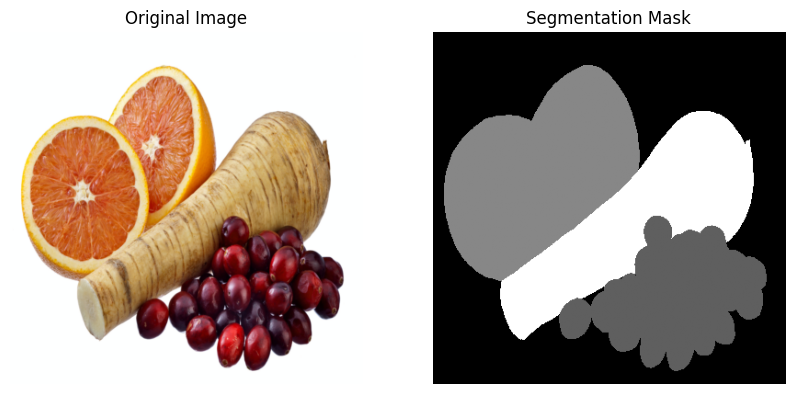

Unique values in mask:  [ 0 31 44 83]
Ingedient:  ['background', 'cherry', 'orange', 'white radish']


In [ ]:
# Function to unnormalize image
def unnormalize(tensor, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
    tensor = tensor.clone().detach().cpu().numpy()
    tensor = tensor * np.array(std).reshape(3, 1, 1) + np.array(mean).reshape(3, 1, 1)
    tensor = np.clip(tensor, 0, 1)  # Clip values to valid range
    return np.transpose(tensor, (1, 2, 0))  # Convert to (H, W, C)

# Get first batch
images, masks = next(iter(train_loader))
image = images[0]  # First image in batch
mask = masks[0]  # First mask in batch

# Unnormalize image
image = unnormalize(image)

# Convert mask to NumPy array for visualization
mask = mask.squeeze(0).cpu().numpy()  # Convert to (H, W)

# Plot the image and mask
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(image)
ax[0].set_title("Original Image")
ax[0].axis("off")

ax[1].imshow(mask, cmap="gray")  # Display mask in grayscale
ax[1].set_title("Segmentation Mask")
ax[1].axis("off")

plt.show()

print("Unique values in mask: ", np.unique(mask))
print("Ingedient: ", df.iloc[np.unique(mask)]['Category'].tolist())

### 2.4 Pre-trained model (DeepLabV3)

In [ ]:
# Load DeepLabV3 with ResNet-101 backbone and COCO-pretrained
model = models.deeplabv3_resnet101(weights=models.DeepLabV3_ResNet101_Weights.COCO_WITH_VOC_LABELS_V1)

# Modify the classifier for FoodSeg103 dataset (104 classes)
num_classes = 104
model.classifier[4] = nn.Conv2d(256, num_classes, kernel_size=1)

# Move model to GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
model.eval()  # Set to evaluation mode

Downloading: "https://download.pytorch.org/models/deeplabv3_resnet101_coco-586e9e4e.pth" to /root/.cache/torch/hub/checkpoints/deeplabv3_resnet101_coco-586e9e4e.pth
100%|██████████| 233M/233M [00:01<00:00, 223MB/s]


DeepLabV3(
  (backbone): IntermediateLayerGetter(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Se

### 2.5 Evaluation

#### 2.5.1 Multi-classes mIoU

In [ ]:
# Load evaluate funtion
mean_iou = evaluate.load("mean_iou", trust_remote_code=True)
num_classes = 104

# Initialize variables to accumulate IoU values
total_mIoU = []
num_batches = 0

# Loop for mIOU calculation
with torch.no_grad():
    for images, masks in tqdm.tqdm(test_loader, desc="Evaluating mIoU", leave=False):
        images, masks = images.to(device), masks.to(device).long()

        # Get model predictions
        outputs = model(images)['out']
        predictions = torch.argmax(outputs, dim=1)  # Convert logits to class indices

        # Convert tensors to numpy
        predicted = predictions.cpu().numpy()
        ground_truth = masks.cpu().numpy()

        # Compute mIoU for the batch
        evaluation_result = mean_iou.compute(predictions=predicted, references=ground_truth,
                                             num_labels=num_classes-1, ignore_index=0)
        batch_mIoU = evaluation_result["mean_iou"]

        # Store result
        total_mIoU.append(batch_mIoU)

Evaluating mIoU:   0%|          | 0/134 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/datasets/features/image.py:347: UserWarning: Downcasting array dtype int64 to int32 to be compatible with 'Pillow'
  warnings.warn(f"Downcasting array dtype {dtype} to {dest_dtype} to be compatible with 'Pillow'")
/root/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/9e450724f21f05592bfb0255fe2fa576df8171fa060d11121d8aecfff0db80d0/mean_iou.py:259: RuntimeWarning: invalid value encountered in divide
  iou = total_area_intersect / total_area_union
/root/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/9e450724f21f05592bfb0255fe2fa576df8171fa060d11121d8aecfff0db80d0/mean_iou.py:260: RuntimeWarning: invalid value encountered in divide
  acc = total_area_intersect / total_area_label


In [ ]:
# Compute mIoU
final_mIoU = np.mean(total_mIoU)
print(f"Dataset Mean IoU: {final_mIoU:.4f}")

Dataset Mean IoU: 0.0016


#### 2.5.2 Binary-class mIoU

In [ ]:
# Load evaluation function
mean_iou = evaluate.load("mean_iou", trust_remote_code=True)

# Define binary classes (0: Background, 1: Food)
num_classes = 2

# Initialize variables to accumulate IoU values
total_mIoU = []
num_batches = 0

# Loop for mIoU calculation
with torch.no_grad():
    for images, masks in tqdm.tqdm(test_loader, desc="Evaluating Binary mIoU", leave=False):
        images, masks = images.to(device), masks.to(device).long()

        # Get model predictions
        outputs = model(images)['out']
        predictions = torch.argmax(outputs, dim=1)  # Convert logits to class indices

        # Convert multi-class to binary class (background: 0, food: 1)
        binary_ground_truth = (masks > 0).long()  # Convert all non-background classes to 1
        binary_predictions = (predictions > 0).long()  # Convert all non-background classes to 1

        # Convert tensors to numpy
        predicted_np = binary_predictions.cpu().numpy()
        ground_truth_np = binary_ground_truth.cpu().numpy()

        # Compute binary mIoU
        evaluation_result = mean_iou.compute(
            predictions=predicted_np,
            references=ground_truth_np,
            num_labels=num_classes,
            ignore_index=255
        )

        batch_mIoU = evaluation_result["mean_iou"]

        # Store result
        total_mIoU.append(batch_mIoU)

In [ ]:
# Print final average mIoU
final_mIoU = np.mean(total_mIoU)
print(f"Binary mIoU: {final_mIoU:.4f}")

Binary mIoU: 0.2649


#### 2.5.3 Example result

Input image 1
Real Ingedient:  ['background', 'pork', 'potato', 'pumpkin', 'white radish', 'shiitake']
Predicted Ingedient:  ['tea', 'egg', 'date', 'lemon', 'pork', 'chicken duck', 'carrot']


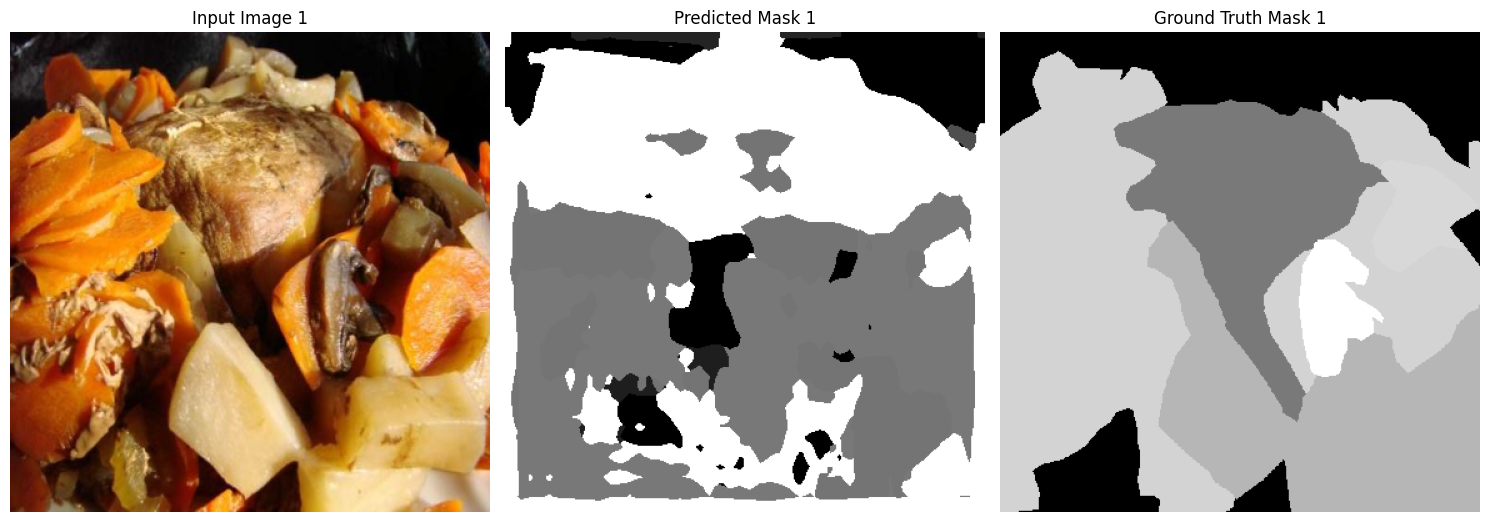

Input image 2
Real Ingedient:  ['background', 'banana', 'sauce', 'crab', 'shrimp']
Predicted Ingedient:  ['sauce', 'carrot']


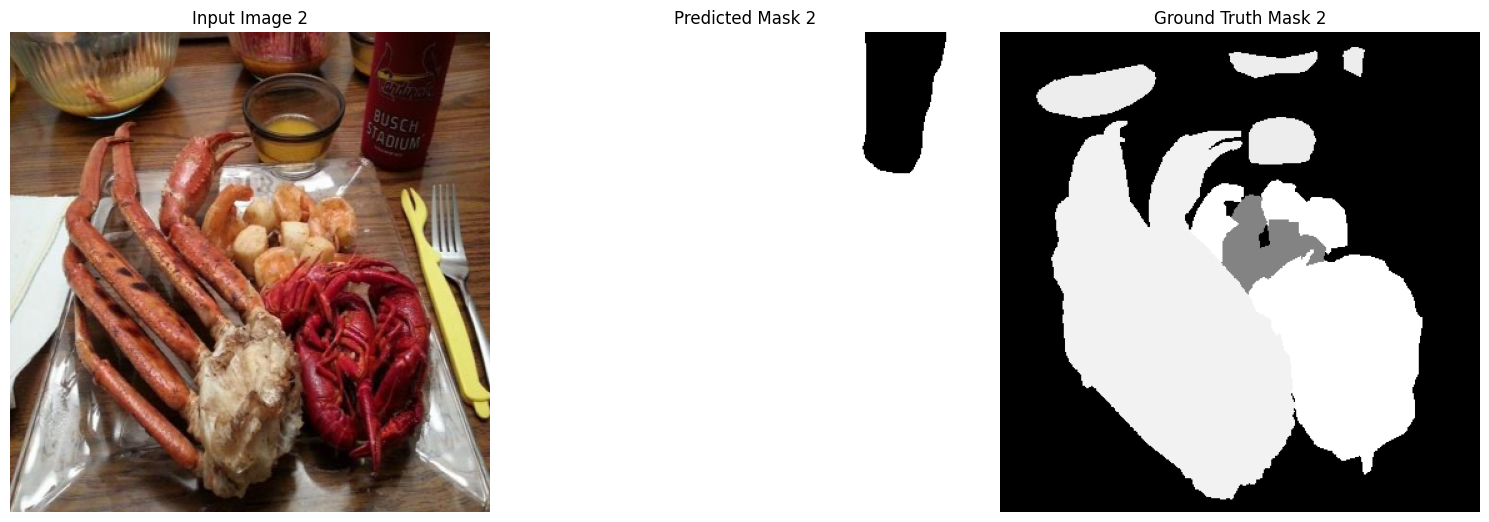

Input image 3
Real Ingedient:  ['background', 'shellfish', 'noodles']
Predicted Ingedient:  ['sauce', 'carrot', 'onion']


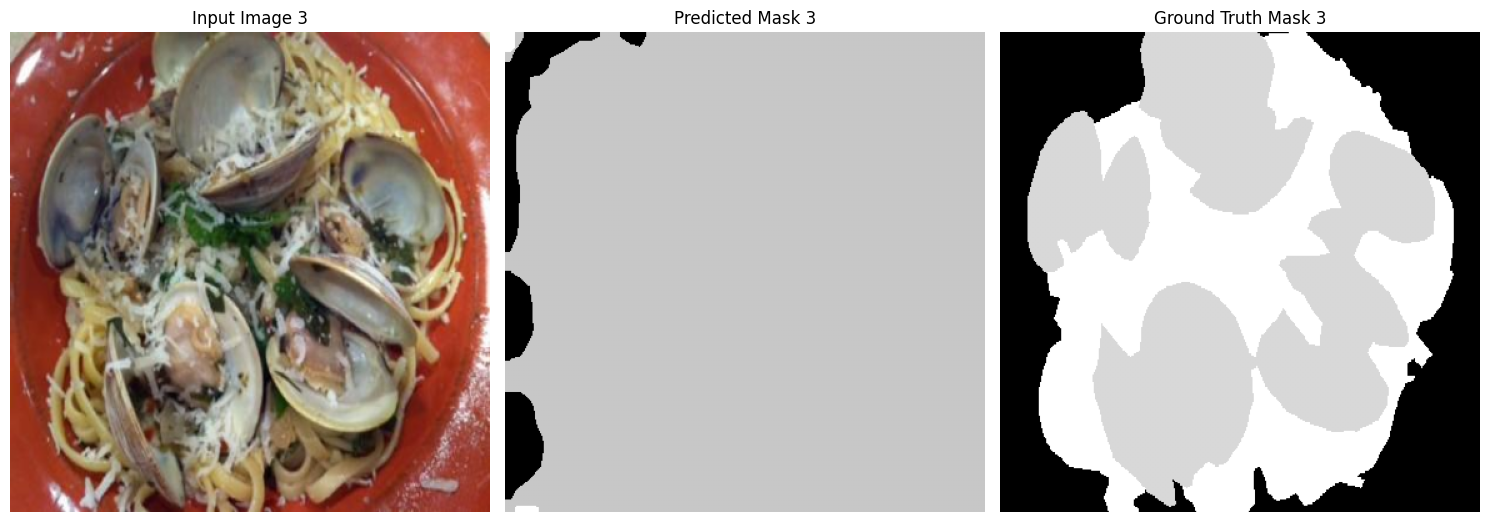

In [ ]:
# Number of images to plot
num_images = 3

for i in range(num_images):

    # Create a figure
    fig, axes = plt.subplots(1, 3, figsize=(15, 5 * num_images))

    # Unnormalize and get images
    input_image = np.clip(images[1].cpu().numpy().transpose(1, 2, 0), 0, 1)
    input_image = unnormalize(images[i])

    # Get predicted and ground truth masks
    predicted_mask = predictions[i].cpu().numpy()
    ground_truth_mask = masks[i].cpu().numpy()

    # Plot input image
    axes[0].imshow(input_image)
    axes[0].set_title(f"Input Image {i+1}")
    axes[0].axis('off')  # Hide axes

    # Plot predicted mask
    axes[1].imshow(predicted_mask, cmap="gray")  # Use grayscale colormap
    axes[1].set_title(f"Predicted Mask {i+1}")
    axes[1].axis('off')

    # Plot ground truth mask
    axes[2].imshow(ground_truth_mask, cmap="gray")
    axes[2].set_title(f"Ground Truth Mask {i+1}")
    axes[2].axis('off')

    # Print real ingredients and predicted ingredients
    print(f"Input image {i+1}")
    print("Real Ingredients: ", df.iloc[np.unique(ground_truth_mask)]['Category'].tolist())
    print("Predicted Ingredients: ", df.iloc[np.unique(predicted_mask)]['Category'].tolist())

    # Adjust layout to prevent overlap
    plt.tight_layout()
    plt.show()

# 3. Fine-tuned DeepLabV3 (RestNet 50) with CLAHE and Cross Entropy Loss

### 3.1 Preprocessing

In [ ]:
# Function for CLAHE (Histogram Equalization)
def apply_clahe(img):
    # Convert tensor to PIL image
    img = F.to_pil_image(img)
    img_np = np.array(img)

    # Convert to LAB color space for better contrast enhancement
    lab = cv2.cvtColor(img_np, cv2.COLOR_RGB2LAB)
    l, a, b = cv2.split(lab)

    # Apply CLAHE only on the L (lightness) channel
    clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8,8))
    l = clahe.apply(l)
    lab_clahe = cv2.merge((l, a, b))

    # Convert back to RGB
    img_clahe = cv2.cvtColor(lab_clahe, cv2.COLOR_LAB2RGB)

    # Convert back to Tensor (C, H, W) and Normalize to [0,1]
    img_tensor = torch.from_numpy(img_clahe).permute(2, 0, 1).float().div(255)

    return img_tensor

# Define image transforms with additional preprocessing
img_transform = transforms.Compose([
    transforms.Resize((384, 384)),
    transforms.ToTensor(),
    transforms.Lambda(lambda x: apply_clahe(x)),  # Apply CLAHE
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Normalize for pre-trained models
])

# Transforms for masks
mask_transform = transforms.Compose([
    transforms.Resize((384, 384), interpolation=transforms.InterpolationMode.NEAREST),
    transforms.ToTensor(),  # Convert to tensor with shape [1, H, W]
    transforms.Lambda(lambda x: (x * 255).long().squeeze(0)),  # Convert [0,1] to [0,255]
])

### 3.2 Create train and test dataset

In [ ]:
# Define paths
data_root = "FoodSeg103/Images"
img_train_dir = os.path.join(data_root, "img_dir/train")
ann_train_dir = os.path.join(data_root, "ann_dir/train")

# Paths to the train split
img_train_ids = 'FoodSeg103/ImageSets/train.txt'

# Load dataset
train_dataset = ImageDataset(img_train_dir, ann_train_dir, img_train_ids, img_transform, mask_transform)

# Set the proportion for validation (90% training, 10% validation)
val_ratio = 0.15
num_train = len(train_dataset)
num_val = int(val_ratio * num_train)
num_train = num_train - num_val

# Split the dataset into train and validation sets
train_dataset, val_dataset = random_split(train_dataset, [num_train, num_val])

# Create DataLoaders
num_workers = min(2, os.cpu_count() // 2)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=num_workers)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False, num_workers=num_workers)

# Optionally, you can also create a test loader
img_test_dir = os.path.join(data_root, "img_dir/test")
ann_test_dir = os.path.join(data_root, "ann_dir/test")
img_test_ids = 'FoodSeg103/ImageSets/test.txt'

test_dataset = ImageDataset(img_test_dir, ann_test_dir, img_test_ids, img_transform, mask_transform)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=num_workers)

### 3.3 Example Image

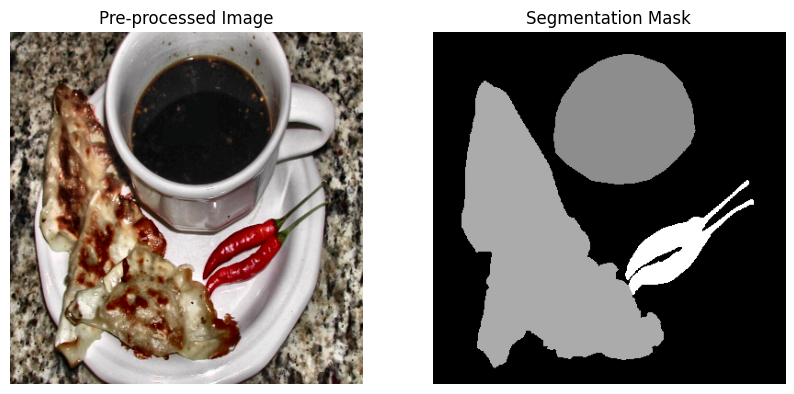

Unique values in mask:  [ 0 52 63 94]
Ingedient:  ['background', 'sauce', 'wonton dumplings', 'pepper']


In [ ]:
# Function to unnormalize image
def unnormalize(tensor, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
    tensor = tensor.clone().detach().cpu().numpy()
    tensor = tensor * np.array(std).reshape(3, 1, 1) + np.array(mean).reshape(3, 1, 1)
    tensor = np.clip(tensor, 0, 1)  # Clip values to valid range
    return np.transpose(tensor, (1, 2, 0))  # Convert to (H, W, C)

# Get first batch
images, masks = next(iter(train_loader))
image = images[0]  # First image in batch
mask = masks[0]  # First mask in batch

# Unnormalize image
image = unnormalize(image)

# Convert mask to NumPy array for visualization
mask = mask.squeeze(0).cpu().numpy()  # Convert to (H, W)

# Plot the image and mask
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(image)
ax[0].set_title("Pre-processed Image")
ax[0].axis("off")

ax[1].imshow(mask, cmap="gray")  # Display mask in grayscale
ax[1].set_title("Segmentation Mask")
ax[1].axis("off")

plt.show()

print("Unique values in mask: ", np.unique(mask))
print("Ingedient: ", df.iloc[np.unique(mask)]['Category'].tolist())

### 3.4 Load base model (DeepLabV3 with RestNet50)

In [ ]:
# Load DeepLabV3 with ResNet-50 Backbone
model = torchvision.models.segmentation.deeplabv3_resnet50(
    weights=torchvision.models.segmentation.DeepLabV3_ResNet50_Weights.COCO_WITH_VOC_LABELS_V1
)

# Modify the classifier to output 104 classes (FoodSeg103)
num_classes = 104
model.classifier[4] = nn.Conv2d(256, num_classes, kernel_size=1)

# Move model to device (GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Unfreeze for fine-tuning
for name, param in model.backbone.named_parameters():
    if  "layer2" in name or "layer3" in name or "layer4" in name or "classifier" in name:
        param.requires_grad = True
    else:
        param.requires_grad = False

# Loss function and optimizer
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4)

# Learning rate scheduler
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)

# Set the model to training mode
model.train()

Downloading: "https://download.pytorch.org/models/deeplabv3_resnet50_coco-cd0a2569.pth" to /root/.cache/torch/hub/checkpoints/deeplabv3_resnet50_coco-cd0a2569.pth
100%|██████████| 161M/161M [00:01<00:00, 127MB/s]


DeepLabV3(
  (backbone): IntermediateLayerGetter(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Se

### 3.5 Fine-tuning

In [ ]:
save_path = "/content/drive/MyDrive/CSC8645_Chatwipa/TASK 1/model"
date = datetime.today().strftime('%Y-%m-%d')

In [ ]:
# Number of epochs
num_epochs = 50

# Best validation loss initialization for model checkpointing
best_val_loss = float('inf')  # Initialize to infinity
patience = 5  # Early stopping patience (number of epochs without improvement)
epochs_without_improvement = 0 # Counter

for epoch in range(num_epochs):
    model.train()  # Set model to training mode
    epoch_loss = 0

    # Training phase
    for images, masks in tqdm.tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Training", unit="batch"):
        images = images.to(device)
        masks = masks.squeeze(1).long().to(device)
        optimizer.zero_grad()  # Clear previous gradients
        outputs = model(images)['out']  # DeepLabV3 output
        loss = criterion(outputs, masks)  # Calculate loss
        loss.backward()  # Backpropagate loss
        optimizer.step()  # Update model weights
        epoch_loss += loss.item()

    # Average training loss for this epoch
    avg_train_loss = epoch_loss / len(train_loader)

    # Validation phase
    model.eval()  # Set model to evaluation mode
    val_loss = 0
    with torch.no_grad():
        for images, masks in tqdm.tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Validation", unit="batch"):
            images = images.to(device)
            masks = masks.squeeze(1).long().to(device)
            outputs = model(images)['out']  # DeepLabV3 output
            loss = criterion(outputs, masks)  # Calculate validation loss
            val_loss += loss.item()

    # Average validation loss for this epoch
    avg_val_loss = val_loss / len(val_loader)
    print(f"Epoch [{epoch+1}/{num_epochs}] - Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")

    # Save the model if validation loss improves
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(model.state_dict(), f'{save_path}/deeplabv3_RestNet50_foodseg103_{date}.pth')
        epochs_without_improvement = 0  # Reset counter for early stopping
    else:
        epochs_without_improvement += 1

    # Early stopping check
    if epochs_without_improvement >= patience:
        print("Early stopping triggered. No improvement in validation loss.")
        break

    # Update learning rate scheduler
    scheduler.step(avg_val_loss)

print("Training complete. Best model saved.")

Epoch 1/50 - Validation: 100%|██████████| 47/47 [00:13<00:00,  3.42batch/s]


Epoch [1/50] - Train Loss: 1.9911, Val Loss: 1.5437


Epoch 2/50 - Validation: 100%|██████████| 47/47 [00:13<00:00,  3.40batch/s]


Epoch [2/50] - Train Loss: 1.3834, Val Loss: 1.2978


Epoch 3/50 - Validation: 100%|██████████| 47/47 [00:13<00:00,  3.41batch/s]


Epoch [3/50] - Train Loss: 1.1658, Val Loss: 1.2112


Epoch 4/50 - Validation: 100%|██████████| 47/47 [00:13<00:00,  3.41batch/s]


Epoch [4/50] - Train Loss: 1.0145, Val Loss: 1.1978


Epoch 5/50 - Validation: 100%|██████████| 47/47 [00:13<00:00,  3.43batch/s]


Epoch [5/50] - Train Loss: 0.8917, Val Loss: 1.1968


Epoch 6/50 - Validation: 100%|██████████| 47/47 [00:13<00:00,  3.40batch/s]


Epoch [6/50] - Train Loss: 0.7816, Val Loss: 1.1602


Epoch 7/50 - Validation: 100%|██████████| 47/47 [00:13<00:00,  3.42batch/s]


Epoch [7/50] - Train Loss: 0.7062, Val Loss: 1.2190


Epoch 8/50 - Validation: 100%|██████████| 47/47 [00:13<00:00,  3.42batch/s]


Epoch [8/50] - Train Loss: 0.6502, Val Loss: 1.2900


Epoch 9/50 - Validation: 100%|██████████| 47/47 [00:13<00:00,  3.41batch/s]


Epoch [9/50] - Train Loss: 0.5788, Val Loss: 1.1888


Epoch 10/50 - Validation: 100%|██████████| 47/47 [00:13<00:00,  3.44batch/s]


Epoch [10/50] - Train Loss: 0.5213, Val Loss: 1.2316


Epoch 11/50 - Validation: 100%|██████████| 47/47 [00:13<00:00,  3.46batch/s]


Epoch [11/50] - Train Loss: 0.3829, Val Loss: 1.0526


Epoch 12/50 - Validation: 100%|██████████| 47/47 [00:13<00:00,  3.43batch/s]


Epoch [12/50] - Train Loss: 0.3165, Val Loss: 1.0553


Epoch 13/50 - Validation: 100%|██████████| 47/47 [00:13<00:00,  3.42batch/s]


Epoch [13/50] - Train Loss: 0.2788, Val Loss: 1.0765


Epoch 14/50 - Validation: 100%|██████████| 47/47 [00:13<00:00,  3.44batch/s]


Epoch [14/50] - Train Loss: 0.2567, Val Loss: 1.0687


Epoch 15/50 - Validation: 100%|██████████| 47/47 [00:13<00:00,  3.47batch/s]


Epoch [15/50] - Train Loss: 0.2393, Val Loss: 1.0923


Epoch 16/50 - Validation: 100%|██████████| 47/47 [00:13<00:00,  3.42batch/s]

Epoch [16/50] - Train Loss: 0.2150, Val Loss: 1.0746
Early stopping triggered. No improvement in validation loss.
Training complete. Best model saved.


### 3.6 Evaluation

In [ ]:
# Path of model
model_path = '/content/drive/MyDrive/CSC8645_Chatwipa/TASK 1/model/deeplabv3_RestNet50_foodseg103_2025-03-30.pth'

In [ ]:
# Load DeepLabV3 model with ResNet-101 backbone
model = torchvision.models.segmentation.deeplabv3_resnet101(weights=None)

# Modify the classifier to match FoodSeg103 (104 classes)
num_classes = 104
model.classifier[4] = torch.nn.Conv2d(256, num_classes, kernel_size=1)

# Move model to device (CPU/GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Load the saved state dict with strict=False
state_dict = torch.load(model_path, map_location=device)

# Filter out unexpected keys
state_dict = {k: v for k, v in state_dict.items() if 'aux_classifier' not in k}
model.load_state_dict(state_dict, strict=False)

# Set model to evaluation mode
model.eval()

DeepLabV3(
  (backbone): IntermediateLayerGetter(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Se

#### 3.6.1 Multi-classes mIoU

In [ ]:
# Load evaluate funtion
mean_iou = evaluate.load("mean_iou", trust_remote_code=True)
num_classes = 104

# Initialize variables to accumulate IoU values
total_mIoU = []
num_batches = 0

# Loop for mIOU calculation
with torch.no_grad():
    for images, masks in tqdm.tqdm(test_loader, desc="Evaluating mIoU", leave=False):
        images, masks = images.to(device), masks.to(device).long()

        # Get model predictions
        outputs = model(images)['out']
        predictions = torch.argmax(outputs, dim=1)  # Convert logits to class indices

        # Convert tensors to numpy
        predicted = predictions.cpu().numpy()
        ground_truth = masks.cpu().numpy()

        # Compute mIoU for the batch
        evaluation_result = mean_iou.compute(predictions=predicted, references=ground_truth,
                                             num_labels=num_classes-1, ignore_index=0)
        batch_mIoU = evaluation_result["mean_iou"]

        # Store result
        total_mIoU.append(batch_mIoU)

Evaluating mIoU:   0%|          | 0/134 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/datasets/features/image.py:347: UserWarning: Downcasting array dtype int64 to int32 to be compatible with 'Pillow'
  warnings.warn(f"Downcasting array dtype {dtype} to {dest_dtype} to be compatible with 'Pillow'")
/root/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/9e450724f21f05592bfb0255fe2fa576df8171fa060d11121d8aecfff0db80d0/mean_iou.py:259: RuntimeWarning: invalid value encountered in divide
  iou = total_area_intersect / total_area_union
/root/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/9e450724f21f05592bfb0255fe2fa576df8171fa060d11121d8aecfff0db80d0/mean_iou.py:260: RuntimeWarning: invalid value encountered in divide
  acc = total_area_intersect / total_area_label


In [ ]:
# Compute mIoU
final_mIoU = np.mean(total_mIoU)
print(f"Dataset Mean IoU: {final_mIoU:.4f}")

Dataset Mean IoU: 0.0025


#### 3.6.2 Binary-class mIoU

In [ ]:
# Load evaluation function
mean_iou = evaluate.load("mean_iou", trust_remote_code=True)

# Define binary classes (0: Background, 1: Food)
num_classes = 2

# Initialize variables to accumulate IoU values
total_mIoU = []
num_batches = 0

# Loop for mIoU calculation
with torch.no_grad():
    for images, masks in tqdm.tqdm(test_loader, desc="Evaluating Binary mIoU", leave=False):
        images, masks = images.to(device), masks.to(device).long()

        # Get model predictions
        outputs = model(images)['out']
        predictions = torch.argmax(outputs, dim=1)  # Convert logits to class indices

        # Convert multi-class to binary class (background: 0, food: 1)
        binary_ground_truth = (masks > 0).long()  # Convert all non-background classes to 1
        binary_predictions = (predictions > 0).long()  # Convert all non-background classes to 1

        # Convert tensors to numpy
        predicted_np = binary_predictions.cpu().numpy()
        ground_truth_np = binary_ground_truth.cpu().numpy()

        # Compute binary mIoU
        evaluation_result = mean_iou.compute(
            predictions=predicted_np,
            references=ground_truth_np,
            num_labels=num_classes,
            ignore_index=255  # Ignore invalid pixels
        )
        batch_mIoU = evaluation_result["mean_iou"]

        # Store result
        total_mIoU.append(batch_mIoU)

In [ ]:
# Print final average mIoU
final_mIoU = np.mean(total_mIoU)
print(f"Binary mIoU: {final_mIoU:.4f}")

Binary mIoU: 0.6275


#### 3.6.3 Example result

In [ ]:
# Number of images to plot
num_images = 3

for i in range(num_images):

    # Create a figure
    fig, axes = plt.subplots(1, 3, figsize=(15, 5 * num_images))

    # Unnormalize and get images
    input_image = unnormalize(images[i])

    # Get predicted and ground truth masks
    predicted_mask = predictions[i].cpu().numpy()
    ground_truth_mask = masks[i].cpu().numpy()

    # Plot input image
    axes[0].imshow(input_image)
    axes[0].set_title(f"Input Image {i+1}")
    axes[0].axis('off')  # Hide axes

    # Plot predicted mask
    axes[1].imshow(predicted_mask, cmap="gray")
    axes[1].set_title(f"Predicted Mask {i+1}")
    axes[1].axis('off')

    # Plot ground truth mask
    axes[2].imshow(ground_truth_mask, cmap="gray")
    axes[2].set_title(f"Ground Truth Mask {i+1}")
    axes[2].axis('off')

    # Print real ingredients and predicted ingredients
    print(f"Input image {i+1}")
    print("Real Ingredients: ", df.iloc[np.unique(ground_truth_mask)]['Category'].tolist())
    print("Predicted Ingredients: ", df.iloc[np.unique(predicted_mask)]['Category'].tolist())

    # Adjust layout to prevent overlap
    plt.tight_layout()
    plt.show()

Output hidden; open in https://colab.research.google.com to view.

# 4. Fine-tuned DeepLabV3 (RestNet 101) with CLAHE and Cross Entropy Loss

### 4.1 Preprocessing

In [ ]:
# Function for CLAHE (Histogram Equalization)
def apply_clahe(img):
    # Convert tensor to PIL image
    img = F.to_pil_image(img)
    img_np = np.array(img)

    # Convert to LAB color space for better contrast enhancement
    lab = cv2.cvtColor(img_np, cv2.COLOR_RGB2LAB)
    l, a, b = cv2.split(lab)

    # Apply CLAHE only on the L (lightness) channel
    clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8,8))
    l = clahe.apply(l)
    lab_clahe = cv2.merge((l, a, b))

    # Convert back to RGB
    img_clahe = cv2.cvtColor(lab_clahe, cv2.COLOR_LAB2RGB)

    # Convert back to Tensor (C, H, W)
    img_tensor = torch.from_numpy(img_clahe).permute(2, 0, 1).float().div(255)  # Normalize to [0,1]

    return img_tensor

# Define image transforms with additional preprocessing
img_transform = transforms.Compose([
    transforms.Resize((384, 384)),
    transforms.ToTensor(),
    transforms.Lambda(lambda x: apply_clahe(x)),  # Apply CLAHE
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Normalize for pre-trained models
])

# Transforms for masks
mask_transform = transforms.Compose([
    transforms.Resize((384, 384), interpolation=transforms.InterpolationMode.NEAREST),
    transforms.ToTensor(),  # Convert to tensor with shape [1, H, W]
    transforms.Lambda(lambda x: (x * 255).long().squeeze(0)),  # Convert [0,1] to [0,255]
])

### 4.2 Create train and test dataset

In [ ]:
# Define paths
data_root = "FoodSeg103/Images"
img_train_dir = os.path.join(data_root, "img_dir/train")
ann_train_dir = os.path.join(data_root, "ann_dir/train")

# Paths to the train split
img_train_ids = 'FoodSeg103/ImageSets/train.txt'

# Load dataset
train_dataset = ImageDataset(img_train_dir, ann_train_dir, img_train_ids, img_transform, mask_transform)

# Set the proportion for validation (90% training, 10% validation)
val_ratio = 0.15
num_train = len(train_dataset)
num_val = int(val_ratio * num_train)
num_train = num_train - num_val

# Split the dataset into train and validation sets
train_dataset, val_dataset = random_split(train_dataset, [num_train, num_val])

# Create DataLoaders
num_workers = min(2, os.cpu_count() // 2)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=num_workers)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False, num_workers=num_workers)

# Optionally, you can also create a test loader
img_test_dir = os.path.join(data_root, "img_dir/test")
ann_test_dir = os.path.join(data_root, "ann_dir/test")
img_test_ids = 'FoodSeg103/ImageSets/test.txt'

test_dataset = ImageDataset(img_test_dir, ann_test_dir, img_test_ids, img_transform, mask_transform)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=num_workers)

### 4.3 Example Image

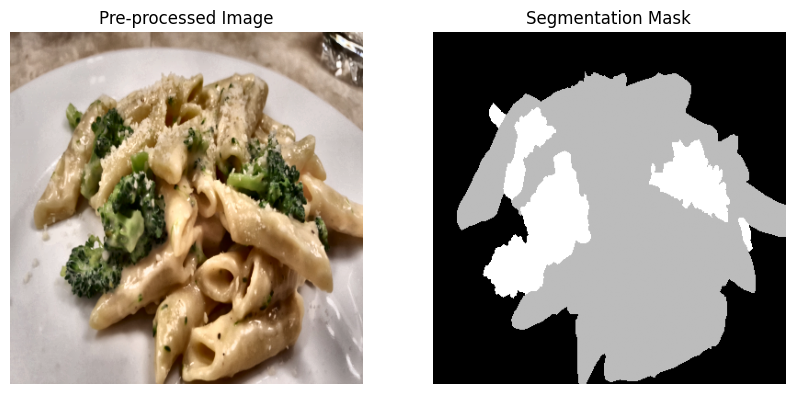

Unique values in mask:  [ 0 64 87]
Ingedient:  ['background', 'pasta', 'broccoli']


In [ ]:
# Function to unnormalize image
def unnormalize(tensor, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
    tensor = tensor.clone().detach().cpu().numpy()
    tensor = tensor * np.array(std).reshape(3, 1, 1) + np.array(mean).reshape(3, 1, 1)
    tensor = np.clip(tensor, 0, 1)  # Clip values to valid range
    return np.transpose(tensor, (1, 2, 0))  # Convert to (H, W, C)

# Get first batch
images, masks = next(iter(train_loader))
image = images[0]  # First image in batch
mask = masks[0]  # First mask in batch

# Unnormalize image
image = unnormalize(image)

# Convert mask to NumPy array for visualization
mask = mask.squeeze(0).cpu().numpy()  # Convert to (H, W)

# Plot the image and mask
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(image)
ax[0].set_title("Pre-processed Image")
ax[0].axis("off")

ax[1].imshow(mask, cmap="gray")  # Display mask in grayscale
ax[1].set_title("Segmentation Mask")
ax[1].axis("off")

plt.show()

print("Unique values in mask: ", np.unique(mask))
print("Ingedient: ", df.iloc[np.unique(mask)]['Category'].tolist())

### 4.4 Load base model (DeepLabV3 with RestNet101)

In [ ]:
# Load DeepLabV3 with ResNet-101 Backbone
model = torchvision.models.segmentation.deeplabv3_resnet101(
    weights=torchvision.models.segmentation.DeepLabV3_ResNet101_Weights.COCO_WITH_VOC_LABELS_V1
)

# Modify the classifier to output 104 classes (FoodSeg103)
num_classes = 104
model.classifier[4] = nn.Conv2d(256, num_classes, kernel_size=1)

# Move model to device (GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Unfreeze for fine-tuning
for name, param in model.backbone.named_parameters():
    if  "layer2" in name or "layer3" in name or "layer4" in name or "classifier" in name:
        param.requires_grad = True
    else:
        param.requires_grad = False

# Loss function and optimizer
criterion = torch.nn.CrossEntropyLoss()  # Loss function for segmentation
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4)

# Learning rate scheduler
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)

# Set the model to training mode
model.train()

DeepLabV3(
  (backbone): IntermediateLayerGetter(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Se

### 4.5 Fine-tuning

In [ ]:
save_path = "/content/drive/MyDrive/CSC8645_Chatwipa/TASK 1/model"
date = datetime.today().strftime('%Y-%m-%d')

In [ ]:
# Number of epochs
num_epochs = 50

# Best validation loss initialization for model checkpointing
best_val_loss = float('inf')  # Initialize to infinity
patience = 5  # Early stopping patience (number of epochs without improvement)
epochs_without_improvement = 0

for epoch in range(num_epochs):
    model.train()  # Set model to training mode
    epoch_loss = 0

    # Training phase
    for images, masks in tqdm.tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Training", unit="batch"):
        images = images.to(device)
        masks = masks.squeeze(1).long().to(device)
        optimizer.zero_grad()  # Clear previous gradients
        outputs = model(images)['out']  # DeepLabV3 output
        loss = criterion(outputs, masks)  # Calculate loss
        loss.backward()  # Backpropagate loss
        optimizer.step()  # Update model weights
        epoch_loss += loss.item()

    # Average training loss for this epoch
    avg_train_loss = epoch_loss / len(train_loader)

    # Validation phase
    model.eval()  # Set model to evaluation mode
    val_loss = 0
    with torch.no_grad():  # No need to track gradients during validation
        for images, masks in tqdm.tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Validation", unit="batch"):
            images = images.to(device)
            masks = masks.squeeze(1).long().to(device)
            outputs = model(images)['out']  # DeepLabV3 output
            loss = criterion(outputs, masks)  # Calculate validation loss
            val_loss += loss.item()

    # Average validation loss for this epoch
    avg_val_loss = val_loss / len(val_loader)
    print(f"Epoch [{epoch+1}/{num_epochs}] - Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")

    # Save the model if validation loss improves
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(model.state_dict(), f'{save_path}/deeplabv3_RestNet101_foodseg103_{date}.pth')
        epochs_without_improvement = 0  # Reset counter for early stopping
    else:
        epochs_without_improvement += 1

    # Early stopping check
    if epochs_without_improvement >= patience:
        print("Early stopping triggered. No improvement in validation loss.")
        break

    # Update learning rate scheduler
    scheduler.step(avg_val_loss)

print("Training complete. Best model saved.")

Epoch 1/50 - Validation: 100%|██████████| 47/47 [00:15<00:00,  2.95batch/s]


Epoch [1/50] - Train Loss: 2.0419, Val Loss: 1.5346


Epoch 2/50 - Validation: 100%|██████████| 47/47 [00:15<00:00,  2.94batch/s]


Epoch [2/50] - Train Loss: 1.4020, Val Loss: 1.2558


Epoch 3/50 - Validation: 100%|██████████| 47/47 [00:16<00:00,  2.94batch/s]


Epoch [3/50] - Train Loss: 1.1640, Val Loss: 1.1664


Epoch 4/50 - Validation: 100%|██████████| 47/47 [00:15<00:00,  2.95batch/s]


Epoch [4/50] - Train Loss: 0.9986, Val Loss: 1.1545


Epoch 5/50 - Validation: 100%|██████████| 47/47 [00:15<00:00,  2.96batch/s]


Epoch [5/50] - Train Loss: 0.8953, Val Loss: 1.1296


Epoch 6/50 - Validation: 100%|██████████| 47/47 [00:15<00:00,  2.94batch/s]


Epoch [6/50] - Train Loss: 0.7850, Val Loss: 1.0762


Epoch 7/50 - Validation: 100%|██████████| 47/47 [00:15<00:00,  2.95batch/s]


Epoch [7/50] - Train Loss: 0.7008, Val Loss: 1.1435


Epoch 8/50 - Validation: 100%|██████████| 47/47 [00:16<00:00,  2.93batch/s]


Epoch [8/50] - Train Loss: 0.6386, Val Loss: 1.1370


Epoch 9/50 - Validation: 100%|██████████| 47/47 [00:15<00:00,  2.95batch/s]


Epoch [9/50] - Train Loss: 0.5822, Val Loss: 1.1702


Epoch 10/50 - Validation: 100%|██████████| 47/47 [00:15<00:00,  2.96batch/s]


Epoch [10/50] - Train Loss: 0.5360, Val Loss: 1.1614


Epoch 11/50 - Validation: 100%|██████████| 47/47 [00:15<00:00,  2.96batch/s]


Epoch [11/50] - Train Loss: 0.3955, Val Loss: 0.9885


Epoch 12/50 - Validation: 100%|██████████| 47/47 [00:16<00:00,  2.93batch/s]


Epoch [12/50] - Train Loss: 0.3166, Val Loss: 0.9933


Epoch 13/50 - Validation: 100%|██████████| 47/47 [00:16<00:00,  2.94batch/s]


Epoch [13/50] - Train Loss: 0.2796, Val Loss: 1.0065


Epoch 14/50 - Validation: 100%|██████████| 47/47 [00:15<00:00,  2.94batch/s]


Epoch [14/50] - Train Loss: 0.2521, Val Loss: 1.0196


Epoch 15/50 - Validation: 100%|██████████| 47/47 [00:16<00:00,  2.92batch/s]


Epoch [15/50] - Train Loss: 0.2320, Val Loss: 1.0263


Epoch 16/50 - Validation: 100%|██████████| 47/47 [00:15<00:00,  2.95batch/s]

Epoch [16/50] - Train Loss: 0.2077, Val Loss: 1.0222
Early stopping triggered. No improvement in validation loss.
Training complete. Best model saved.


### 4.6 Evaluation

In [ ]:
# Path of model
model_path = '/content/drive/MyDrive/CSC8645_Chatwipa/TASK 1/model/deeplabv3_RestNet101_foodseg103_2025-03-30.pth'

In [ ]:
# Load DeepLabV3 model with ResNet-101 backbone
model = torchvision.models.segmentation.deeplabv3_resnet101(weights=None)  # No pre-trained weights

# Modify the classifier to match FoodSeg103 (104 classes)
num_classes = 104
model.classifier[4] = torch.nn.Conv2d(256, num_classes, kernel_size=1)

# Move model to device (CPU/GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Load the saved state dict with strict=False
state_dict = torch.load(model_path, map_location=device)
# Filter out unexpected keys
state_dict = {k: v for k, v in state_dict.items() if 'aux_classifier' not in k}
model.load_state_dict(state_dict, strict=False)

# Set model to evaluation mode
model.eval()

DeepLabV3(
  (backbone): IntermediateLayerGetter(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Se

#### 4.6.1 Multi-classes mIoU

In [ ]:
# Load evaluate funtion
mean_iou = evaluate.load("mean_iou", trust_remote_code=True)
num_classes = 104

# Initialize variables to accumulate IoU values
total_mIoU = []
num_batches = 0

# Loop for mIOU calculation
with torch.no_grad():
    for images, masks in tqdm.tqdm(test_loader, desc="Evaluating mIoU", leave=False):
        images, masks = images.to(device), masks.to(device).long()

        # Get model predictions
        outputs = model(images)['out']
        predictions = torch.argmax(outputs, dim=1)  # Convert logits to class indices

        # Convert tensors to numpy
        predicted = predictions.cpu().numpy()
        ground_truth = masks.cpu().numpy()

        # Compute mIoU for the batch
        evaluation_result = mean_iou.compute(predictions=predicted, references=ground_truth,
                                             num_labels=num_classes-1, ignore_index=0)
        batch_mIoU = evaluation_result["mean_iou"]

        # Store result
        total_mIoU.append(batch_mIoU)

In [ ]:
# Compute mIoU
final_mIoU = np.mean(total_mIoU)
print(f"Dataset Mean IoU: {final_mIoU:.4f}")

Dataset Mean IoU: 0.2374


#### 4.6.2 Binary-class mIoU

In [ ]:
# Load evaluation function
mean_iou = evaluate.load("mean_iou", trust_remote_code=True)

# Define binary classes (0: Background, 1: Food)
num_classes = 2

# Initialize variables to accumulate IoU values
total_mIoU = []
num_batches = 0

# Loop for mIoU calculation
with torch.no_grad():
    for images, masks in tqdm.tqdm(test_loader, desc="Evaluating Binary mIoU", leave=False):
        images, masks = images.to(device), masks.to(device).long()

        # Get model predictions
        outputs = model(images)['out']
        predictions = torch.argmax(outputs, dim=1)  # Convert logits to class indices

        # Convert multi-class to binary class (background: 0, food: 1)
        binary_ground_truth = (masks > 0).long()  # Convert all non-background classes to 1
        binary_predictions = (predictions > 0).long()  # Convert all non-background classes to 1

        # Convert tensors to numpy
        predicted_np = binary_predictions.cpu().numpy()
        ground_truth_np = binary_ground_truth.cpu().numpy()

        # Compute binary mIoU
        evaluation_result = mean_iou.compute(
            predictions=predicted_np,
            references=ground_truth_np,
            num_labels=num_classes,
            ignore_index=255  # Ignore invalid pixels
        )
        batch_mIoU = evaluation_result["mean_iou"]

        # Store result
        total_mIoU.append(batch_mIoU)

In [ ]:
# Print final average mIoU
final_mIoU = np.mean(total_mIoU)
print(f"Binary mIoU: {final_mIoU:.4f}")

Binary mIoU: 0.9150


#### 4.6.3 Example result

In [ ]:
# Number of images to plot
num_images = 3

for i in range(num_images):

    # Create a figure
    fig, axes = plt.subplots(1, 3, figsize=(15, 5 * num_images))

    # Unnormalize and get images
    input_image = unnormalize(images[i])

    # Get predicted and ground truth masks
    predicted_mask = predictions[i].cpu().numpy()
    ground_truth_mask = masks[i].cpu().numpy()

    # Plot input image
    axes[0].imshow(input_image)
    axes[0].set_title(f"Input Image {i+1}")
    axes[0].axis('off')  # Hide axes

    # Plot predicted mask
    axes[1].imshow(predicted_mask, cmap="gray")
    axes[1].set_title(f"Predicted Mask {i+1}")
    axes[1].axis('off')

    # Plot ground truth mask
    axes[2].imshow(ground_truth_mask, cmap="gray")
    axes[2].set_title(f"Ground Truth Mask {i+1}")
    axes[2].axis('off')

    # Print real ingredients and predicted ingredients
    print(f"Input image {i+1}")
    print("Real Ingredients: ", df.iloc[np.unique(ground_truth_mask)]['Category'].tolist())
    print("Predicted Ingredients: ", df.iloc[np.unique(predicted_mask)]['Category'].tolist())

    # Adjust layout to prevent overlap
    plt.tight_layout()
    plt.show()

Output hidden; open in https://colab.research.google.com to view.

# 5. Fine tune DeepLabV3 (RestNet 101), CLAHE and Dice Loss

### 5.1 Preprocessing

In [ ]:
# Function for CLAHE (Histogram Equalization)
def apply_clahe(img):
    # Convert tensor to PIL image
    img = torchvision.transforms.functional.to_pil_image(img)
    img_np = np.array(img)

    # Convert to LAB color space for better contrast enhancement
    lab = cv2.cvtColor(img_np, cv2.COLOR_RGB2LAB)
    l, a, b = cv2.split(lab)

    # Apply CLAHE only on the L (lightness) channel
    clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8,8))
    l = clahe.apply(l)
    lab_clahe = cv2.merge((l, a, b))

    # Convert back to RGB
    img_clahe = cv2.cvtColor(lab_clahe, cv2.COLOR_LAB2RGB)

    # Convert back to Tensor (C, H, W)
    img_tensor = torch.from_numpy(img_clahe).permute(2, 0, 1).float().div(255)  # Normalize to [0,1]

    return img_tensor

# Define image transforms with additional preprocessing
img_transform = transforms.Compose([
    transforms.Resize((384, 384)),
    transforms.ToTensor(),
    transforms.Lambda(lambda x: apply_clahe(x)),  # Apply CLAHE
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Normalize for pre-trained models
])

# Transforms for masks
mask_transform = transforms.Compose([
    transforms.Resize((384, 384), interpolation=transforms.InterpolationMode.NEAREST),  # Resize using nearest neighbor
    transforms.ToTensor(),  # Convert to tensor with shape [1, H, W]
    transforms.Lambda(lambda x: (x * 255).long().squeeze(0)),  # Convert [0,1] to [0,255] and remove extra channel
])

### 5.2 Create train and test dataset

In [ ]:
# Define paths
data_root = "FoodSeg103/Images"
img_train_dir = os.path.join(data_root, "img_dir/train")
ann_train_dir = os.path.join(data_root, "ann_dir/train")

# Paths to the train split
img_train_ids = 'FoodSeg103/ImageSets/train.txt'

# Load dataset
train_dataset = ImageDataset(img_train_dir, ann_train_dir, img_train_ids, img_transform, mask_transform)

# Set the proportion for validation (90% training, 10% validation)
val_ratio = 0.15
num_train = len(train_dataset)
num_val = int(val_ratio * num_train)
num_train = num_train - num_val

# Split the dataset into train and validation sets
train_dataset, val_dataset = random_split(train_dataset, [num_train, num_val])

# Create DataLoaders
num_workers = min(2, os.cpu_count() // 2)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=num_workers)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False, num_workers=num_workers)

# Optionally, you can also create a test loader
img_test_dir = os.path.join(data_root, "img_dir/test")
ann_test_dir = os.path.join(data_root, "ann_dir/test")
img_test_ids = 'FoodSeg103/ImageSets/test.txt'

test_dataset = ImageDataset(img_test_dir, ann_test_dir, img_test_ids, img_transform, mask_transform)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=num_workers)

### 5.3 Example Image

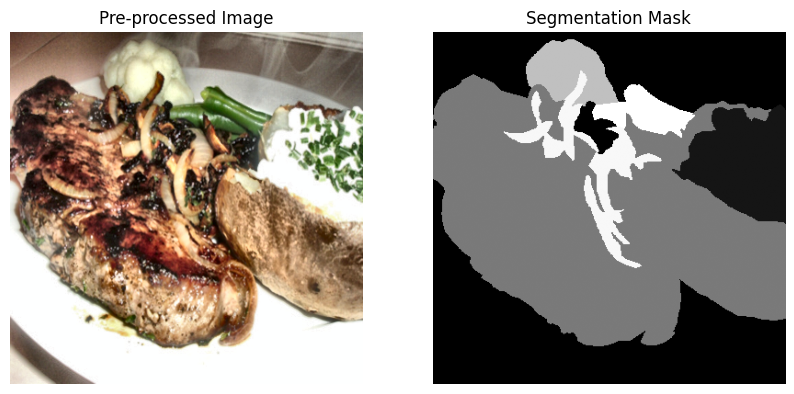

Unique values in mask:  [ 0  8 46 72 93 96]
Ingedient:  ['background', 'ice cream', 'steak', 'cauliflower', 'onion', 'French beans']


In [ ]:
# Function to unnormalize image
def unnormalize(tensor, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
    tensor = tensor.clone().detach().cpu().numpy()
    tensor = tensor * np.array(std).reshape(3, 1, 1) + np.array(mean).reshape(3, 1, 1)
    tensor = np.clip(tensor, 0, 1)  # Clip values to valid range
    return np.transpose(tensor, (1, 2, 0))  # Convert to (H, W, C)

# Get first batch
images, masks = next(iter(train_loader))
image = images[0]  # First image in batch
mask = masks[0]  # First mask in batch

# Unnormalize image
image = unnormalize(image)

# Convert mask to NumPy array for visualization
mask = mask.squeeze(0).cpu().numpy()  # Convert to (H, W)

# Plot the image and mask
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(image)
ax[0].set_title("Pre-processed Image")
ax[0].axis("off")

ax[1].imshow(mask, cmap="gray")  # Display mask in grayscale
ax[1].set_title("Segmentation Mask")
ax[1].axis("off")

plt.show()

print("Unique values in mask: ", np.unique(mask))
print("Ingedient: ", df.iloc[np.unique(mask)]['Category'].tolist())

### 5.4 Load base model (DeepLabV3 with RestNet101)

In [ ]:
# Dice Loss Created by: Zhang Shuai
class DiceLoss(nn.Module):
    """Dice Loss PyTorch
        Created by: Zhang Shuai
        Email: shuaizzz666@gmail.com
        dice_loss = 1 - 2*p*t / (p^2 + t^2). p and t represent predict and target.
    Args:
        weight: An array of shape [C,]
        predict: A float32 tensor of shape [N, C, *], for Semantic segmentation task is [N, C, H, W]
        target: A int64 tensor of shape [N, *], for Semantic segmentation task is [N, H, W]
    Return:
        diceloss
    """
    def __init__(self, weight=None):
        super(DiceLoss, self).__init__()
        if weight is not None:
            weight = torch.Tensor(weight)
            self.weight = weight / torch.sum(weight) # Normalized weight
        self.smooth = 1e-5

    def forward(self, predict, target):
        N, C = predict.size()[:2]
        predict = predict.view(N, C, -1) # (N, C, *)
        target = target.view(N, 1, -1) # (N, 1, *)

        predict = torch.nn.functional.softmax(predict, dim=1) # (N, C, *) ==> (N, C, *)
        ## convert target(N, 1, *) into one hot vector (N, C, *)
        target_onehot = torch.zeros(predict.size()).cuda()  # (N, 1, *) ==> (N, C, *)
        target_onehot.scatter_(1, target, 1)  # (N, C, *)

        intersection = torch.sum(predict * target_onehot, dim=2)  # (N, C)
        union = torch.sum(predict.pow(2), dim=2) + torch.sum(target_onehot, dim=2)  # (N, C)
        ## p^2 + t^2 >= 2*p*t, target_onehot^2 == target_onehot
        dice_coef = (2 * intersection + self.smooth) / (union + self.smooth)  # (N, C)

        if hasattr(self, 'weight'):
            if self.weight.type() != predict.type():
                self.weight = self.weight.type_as(predict)
                dice_coef = dice_coef * self.weight * C  # (N, C)
        dice_loss = 1 - torch.mean(dice_coef)  # 1

        return dice_loss

In [ ]:
# Load DeepLabV3 with ResNet-101 Backbone
model = torchvision.models.segmentation.deeplabv3_resnet101(
    weights=torchvision.models.segmentation.DeepLabV3_ResNet101_Weights.COCO_WITH_VOC_LABELS_V1
)

# Modify the classifier to output 104 classes (FoodSeg103)
num_classes = 104
model.classifier[4] = nn.Conv2d(256, num_classes, kernel_size=1)

# Move model to device (GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Unfreeze for fine-tuning
for name, param in model.backbone.named_parameters():
    if  "layer2" in name or "layer3" in name or "layer4" in name or "classifier" in name:
        param.requires_grad = True
    else:
        param.requires_grad = False

# Loss function and optimizer
criterion = DiceLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4)

# Learning rate scheduler
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)

# Set the model to training mode
model.train()

DeepLabV3(
  (backbone): IntermediateLayerGetter(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Se

### 5.5 Fine-tuning

In [ ]:
save_path = "/content/drive/MyDrive/CSC8645_Chatwipa/TASK 1/model"
date = datetime.today().strftime('%Y-%m-%d')

In [ ]:
# Number of epochs
num_epochs = 50

# Best validation loss initialization for model checkpointing
best_val_loss = float('inf')  # Initialize to infinity
patience = 5  # Early stopping patience (number of epochs without improvement)
epochs_without_improvement = 0

for epoch in range(num_epochs):
    model.train()  # Set model to training mode
    epoch_loss = 0

    # Training phase
    for images, masks in tqdm.tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Training", unit="batch"):
        images = images.to(device)
        masks = masks.squeeze(1).long().to(device)
        optimizer.zero_grad()
        outputs = model(images)['out']

        # Calculate loss
        loss = criterion(outputs, masks)
        loss.backward()

        # Update model weights
        optimizer.step()
        epoch_loss += loss.item()

    # Average training loss for this epoch
    avg_train_loss = epoch_loss / len(train_loader)

    # Validation phase
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for images, masks in tqdm.tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Validation", unit="batch"):
            images = images.to(device)
            masks = masks.squeeze(1).long().to(device)
            outputs = model(images)['out']

            # Calculate loss
            loss = criterion(outputs, masks)
            val_loss += loss.item()

    # Average validation loss for this epoch
    avg_val_loss = val_loss / len(val_loader)
    print(f"Epoch [{epoch+1}/{num_epochs}] - Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")

    # Save the model if validation loss improves
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(model.state_dict(), f'{save_path}/deeplabv3_DiceLoss_foodseg103_{date}.pth')
        epochs_without_improvement = 0  # Reset counter for early stopping
    else:
        epochs_without_improvement += 1

    # Early stopping check
    if epochs_without_improvement >= patience:
        print("Early stopping triggered. No improvement in validation loss.")
        break

    # Update learning rate scheduler
    scheduler.step(avg_val_loss)

print("Training complete. Best model saved.")

Epoch 1/50 - Validation: 100%|██████████| 47/47 [00:21<00:00,  2.18batch/s]


Epoch [1/50] - Train Loss: 0.9992, Val Loss: 0.9992


Epoch 2/50 - Validation: 100%|██████████| 47/47 [00:21<00:00,  2.18batch/s]


Epoch [2/50] - Train Loss: 0.9992, Val Loss: 0.9992


Epoch 3/50 - Validation: 100%|██████████| 47/47 [00:21<00:00,  2.18batch/s]


Epoch [3/50] - Train Loss: 0.9991, Val Loss: 0.9991


Epoch 4/50 - Validation: 100%|██████████| 47/47 [00:21<00:00,  2.17batch/s]


Epoch [4/50] - Train Loss: 0.9991, Val Loss: 0.9991


Epoch 5/50 - Validation: 100%|██████████| 47/47 [00:21<00:00,  2.17batch/s]


Epoch [5/50] - Train Loss: 0.9991, Val Loss: 0.9991


Epoch 6/50 - Validation: 100%|██████████| 47/47 [00:21<00:00,  2.18batch/s]


Epoch [6/50] - Train Loss: 0.9991, Val Loss: 0.9991


Epoch 7/50 - Validation: 100%|██████████| 47/47 [00:21<00:00,  2.18batch/s]


Epoch [7/50] - Train Loss: 0.9991, Val Loss: 0.9991


Epoch 8/50 - Validation: 100%|██████████| 47/47 [00:21<00:00,  2.18batch/s]


Epoch [8/50] - Train Loss: 0.9990, Val Loss: 0.9990


Epoch 9/50 - Validation: 100%|██████████| 47/47 [00:21<00:00,  2.19batch/s]


Epoch [9/50] - Train Loss: 0.9990, Val Loss: 0.9990


Epoch 10/50 - Validation: 100%|██████████| 47/47 [00:21<00:00,  2.18batch/s]


Epoch [10/50] - Train Loss: 0.9990, Val Loss: 0.9990


Epoch 11/50 - Validation: 100%|██████████| 47/47 [00:21<00:00,  2.18batch/s]


Epoch [11/50] - Train Loss: 0.9990, Val Loss: 0.9990


Epoch 12/50 - Validation: 100%|██████████| 47/47 [00:21<00:00,  2.19batch/s]


Epoch [12/50] - Train Loss: 0.9990, Val Loss: 0.9990


Epoch 13/50 - Validation: 100%|██████████| 47/47 [00:21<00:00,  2.18batch/s]


Epoch [13/50] - Train Loss: 0.9990, Val Loss: 0.9990


Epoch 14/50 - Validation: 100%|██████████| 47/47 [00:21<00:00,  2.17batch/s]


Epoch [14/50] - Train Loss: 0.9989, Val Loss: 0.9990


Epoch 15/50 - Validation: 100%|██████████| 47/47 [00:21<00:00,  2.18batch/s]


Epoch [15/50] - Train Loss: 0.9989, Val Loss: 0.9989


Epoch 16/50 - Validation: 100%|██████████| 47/47 [00:21<00:00,  2.19batch/s]


Epoch [16/50] - Train Loss: 0.9989, Val Loss: 0.9989


Epoch 17/50 - Validation: 100%|██████████| 47/47 [00:21<00:00,  2.19batch/s]


Epoch [17/50] - Train Loss: 0.9989, Val Loss: 0.9989


Epoch 18/50 - Validation: 100%|██████████| 47/47 [00:21<00:00,  2.18batch/s]


Epoch [18/50] - Train Loss: 0.9989, Val Loss: 0.9989


Epoch 19/50 - Validation: 100%|██████████| 47/47 [00:21<00:00,  2.16batch/s]


Epoch [19/50] - Train Loss: 0.9989, Val Loss: 0.9989


Epoch 20/50 - Validation: 100%|██████████| 47/47 [00:21<00:00,  2.18batch/s]


Epoch [20/50] - Train Loss: 0.9989, Val Loss: 0.9989


Epoch 21/50 - Validation: 100%|██████████| 47/47 [00:21<00:00,  2.18batch/s]


Epoch [21/50] - Train Loss: 0.9989, Val Loss: 0.9989


Epoch 22/50 - Validation: 100%|██████████| 47/47 [00:21<00:00,  2.17batch/s]


Epoch [22/50] - Train Loss: 0.9988, Val Loss: 0.9989


Epoch 23/50 - Validation: 100%|██████████| 47/47 [00:21<00:00,  2.18batch/s]


Epoch [23/50] - Train Loss: 0.9988, Val Loss: 0.9988


Epoch 24/50 - Validation: 100%|██████████| 47/47 [00:21<00:00,  2.17batch/s]


Epoch [24/50] - Train Loss: 0.9988, Val Loss: 0.9988


Epoch 25/50 - Validation: 100%|██████████| 47/47 [00:21<00:00,  2.18batch/s]


Epoch [25/50] - Train Loss: 0.9988, Val Loss: 0.9988


Epoch 26/50 - Validation: 100%|██████████| 47/47 [00:21<00:00,  2.18batch/s]


Epoch [26/50] - Train Loss: 0.9988, Val Loss: 0.9988


Epoch 27/50 - Validation: 100%|██████████| 47/47 [00:21<00:00,  2.18batch/s]


Epoch [27/50] - Train Loss: 0.9988, Val Loss: 0.9988


Epoch 28/50 - Validation: 100%|██████████| 47/47 [00:21<00:00,  2.18batch/s]


Epoch [28/50] - Train Loss: 0.9988, Val Loss: 0.9988


Epoch 29/50 - Validation: 100%|██████████| 47/47 [00:21<00:00,  2.18batch/s]


Epoch [29/50] - Train Loss: 0.9988, Val Loss: 0.9988


Epoch 30/50 - Validation: 100%|██████████| 47/47 [00:21<00:00,  2.17batch/s]


Epoch [30/50] - Train Loss: 0.9988, Val Loss: 0.9988


Epoch 31/50 - Validation: 100%|██████████| 47/47 [00:21<00:00,  2.18batch/s]


Epoch [31/50] - Train Loss: 0.9988, Val Loss: 0.9988


Epoch 32/50 - Training:   5%|▌         | 14/265 [00:10<03:15,  1.29batch/s]


### 5.6 Evaluation

In [ ]:
# Path of model
model_path = '/content/drive/MyDrive/CSC8645_Chatwipa/TASK 1/model/deeplabv3_DiceLoss_foodseg103_2025-03-30.pth'

In [ ]:
# Load DeepLabV3 model with ResNet-101 backbone
model = torchvision.models.segmentation.deeplabv3_resnet101(weights=None)  # No pre-trained weights

# Modify the classifier to match FoodSeg103 (104 classes)
num_classes = 104
model.classifier[4] = torch.nn.Conv2d(256, num_classes, kernel_size=1)

# Move model to device (CPU/GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Load the saved state dict with strict=False
state_dict = torch.load(model_path, map_location=device)
# Filter out unexpected keys
state_dict = {k: v for k, v in state_dict.items() if 'aux_classifier' not in k}
model.load_state_dict(state_dict, strict=False)

# Set model to evaluation mode
model.eval()

Downloading: "https://download.pytorch.org/models/resnet101-63fe2227.pth" to /root/.cache/torch/hub/checkpoints/resnet101-63fe2227.pth
100%|██████████| 171M/171M [00:00<00:00, 228MB/s]


DeepLabV3(
  (backbone): IntermediateLayerGetter(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Se

#### 5.6.1 Multi-classes mIoU

In [ ]:
# Load evaluate funtion
mean_iou = evaluate.load("mean_iou", trust_remote_code=True)
num_classes = 104

# Initialize variables to accumulate IoU values
total_mIoU = []
num_batches = 0

# Loop for mIOU calculation
with torch.no_grad():
    for images, masks in tqdm.tqdm(test_loader, desc="Evaluating mIoU", leave=False):
        images, masks = images.to(device), masks.to(device).long()

        # Get model predictions
        outputs = model(images)['out']
        predictions = torch.argmax(outputs, dim=1)  # Convert logits to class indices

        # Convert tensors to numpy
        predicted = predictions.cpu().numpy()
        ground_truth = masks.cpu().numpy()

        # Compute mIoU for the batch
        evaluation_result = mean_iou.compute(predictions=predicted, references=ground_truth,
                                             num_labels=num_classes-1, ignore_index=0)
        batch_mIoU = evaluation_result["mean_iou"]

        # Store result
        total_mIoU.append(batch_mIoU)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Evaluating mIoU:   0%|          | 0/134 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/datasets/features/image.py:347: UserWarning: Downcasting array dtype int64 to int32 to be compatible with 'Pillow'
  warnings.warn(f"Downcasting array dtype {dtype} to {dest_dtype} to be compatible with 'Pillow'")
/root/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/9e450724f21f05592bfb0255fe2fa576df8171fa060d11121d8aecfff0db80d0/mean_iou.py:259: RuntimeWarning: invalid value encountered in divide
  iou = total_area_intersect / total_area_union
/root/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/9e450724f21f05592bfb0255fe2fa576df8171fa060d11121d8aecfff0db80d0/mean_iou.py:260: RuntimeWarning: invalid value encountered in divide
  acc = total_area_intersect / total_area_label


In [ ]:
# Compute mIoU
final_mIoU = np.mean(total_mIoU)
print(f"Dataset Mean IoU: {final_mIoU:.4f}")

Dataset Mean IoU: 0.0146


#### 5.6.2 Binary-class mIoU

In [ ]:
# Load evaluation function
mean_iou = evaluate.load("mean_iou", trust_remote_code=True)

# Define binary classes (0: Background, 1: Food)
num_classes = 2

# Initialize variables to accumulate IoU values
total_mIoU = []
num_batches = 0

# Loop for mIoU calculation
with torch.no_grad():
    for images, masks in tqdm.tqdm(test_loader, desc="Evaluating Binary mIoU", leave=False):
        images, masks = images.to(device), masks.to(device).long()

        # Get model predictions
        outputs = model(images)['out']
        predictions = torch.argmax(outputs, dim=1)  # Convert logits to class indices

        # Convert multi-class to binary class (background: 0, food: 1)
        binary_ground_truth = (masks > 0).long()  # Convert all non-background classes to 1
        binary_predictions = (predictions > 0).long()  # Convert all non-background classes to 1

        # Convert tensors to numpy
        predicted_np = binary_predictions.cpu().numpy()
        ground_truth_np = binary_ground_truth.cpu().numpy()

        # Compute binary mIoU
        evaluation_result = mean_iou.compute(
            predictions=predicted_np,
            references=ground_truth_np,
            num_labels=num_classes,
            ignore_index=255  # Ignore invalid pixels
        )
        batch_mIoU = evaluation_result["mean_iou"]

        # Store result
        total_mIoU.append(batch_mIoU)

In [ ]:
# Print final average mIoU
final_mIoU = np.mean(total_mIoU)
print(f"Binary mIoU: {final_mIoU:.4f}")

Binary mIoU: 0.2351


#### 5.6.3 Example result

Input image 1
Real Ingredients:  ['background', 'pork', 'potato', 'pumpkin', 'white radish', 'shiitake']
Predicted Ingredients:  ['background']


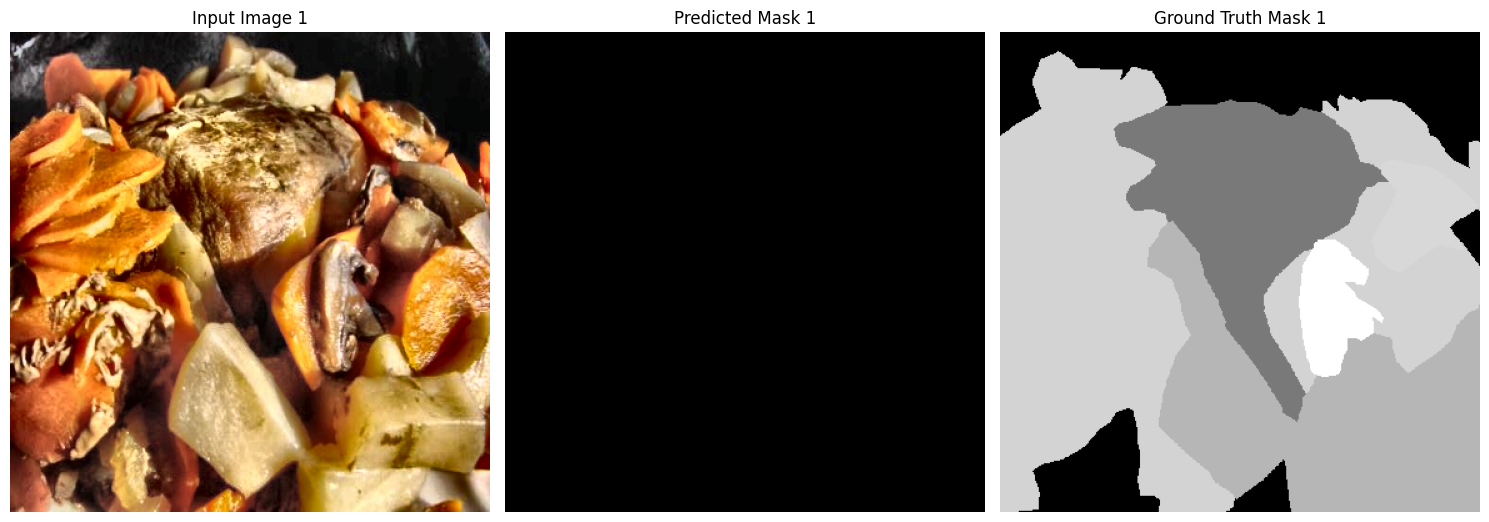

Input image 2
Real Ingredients:  ['background', 'banana', 'sauce', 'crab', 'shrimp']
Predicted Ingredients:  ['background']


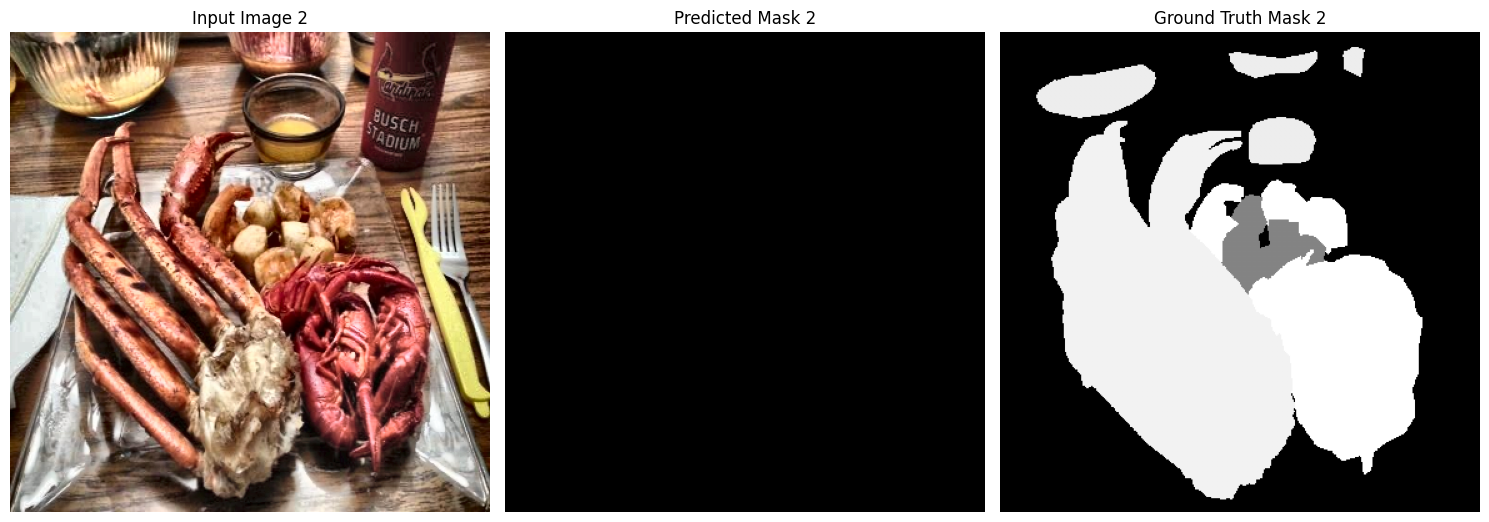

Input image 3
Real Ingredients:  ['background', 'shellfish', 'noodles']
Predicted Ingredients:  ['background']


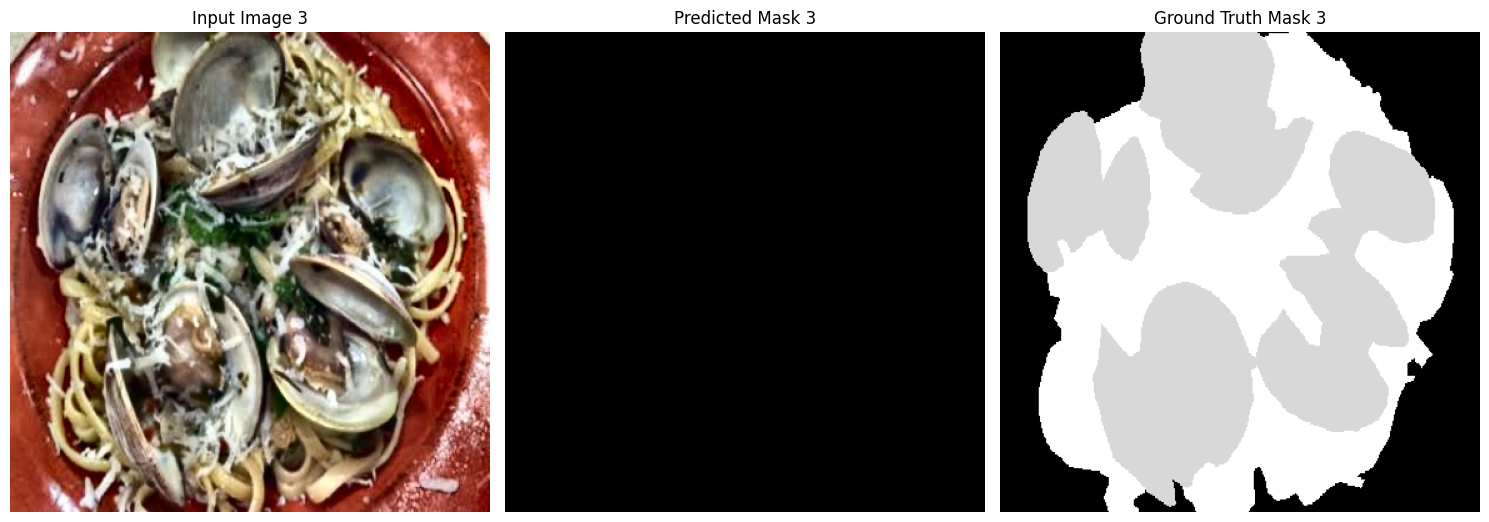

In [ ]:
# Number of images to plot
num_images = 3

for i in range(num_images):

    # Create a figure
    fig, axes = plt.subplots(1, 3, figsize=(15, 5 * num_images))

    # Unnormalize and get images
    input_image = unnormalize(images[i])

    # Get predicted and ground truth masks
    predicted_mask = predictions[i].cpu().numpy()
    ground_truth_mask = masks[i].cpu().numpy()

    # Plot input image
    axes[0].imshow(input_image)
    axes[0].set_title(f"Input Image {i+1}")
    axes[0].axis('off')

    # Plot predicted mask
    axes[1].imshow(predicted_mask, cmap="gray")
    axes[1].set_title(f"Predicted Mask {i+1}")
    axes[1].axis('off')

    # Plot ground truth mask
    axes[2].imshow(ground_truth_mask, cmap="gray")
    axes[2].set_title(f"Ground Truth Mask {i+1}")
    axes[2].axis('off')

    # Print real ingredients and predicted ingredients
    print(f"Input image {i+1}")
    print("Real Ingredients: ", df.iloc[np.unique(ground_truth_mask)]['Category'].tolist())
    print("Predicted Ingredients: ", df.iloc[np.unique(predicted_mask)]['Category'].tolist())

    # Adjust layout to prevent overlap
    plt.tight_layout()
    plt.show()

# 6. Fine tune DeepLabV3 (RestNet 101), CLAHE and Hybrid Loss

### 6.1 Preprocessing

In [ ]:
# Function for CLAHE (Histogram Equalization)
def apply_clahe(img):
    # Convert tensor to PIL image
    img = torchvision.transforms.functional.to_pil_image(img)
    img_np = np.array(img)

    # Convert to LAB color space for better contrast enhancement
    lab = cv2.cvtColor(img_np, cv2.COLOR_RGB2LAB)
    l, a, b = cv2.split(lab)

    # Apply CLAHE only on the L (lightness) channel
    clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8,8))
    l = clahe.apply(l)
    lab_clahe = cv2.merge((l, a, b))

    # Convert back to RGB
    img_clahe = cv2.cvtColor(lab_clahe, cv2.COLOR_LAB2RGB)

    # Convert back to Tensor (C, H, W)
    img_tensor = torch.from_numpy(img_clahe).permute(2, 0, 1).float().div(255)  # Normalize to [0,1]

    return img_tensor

# Define image transforms with additional preprocessing
img_transform = transforms.Compose([
    transforms.Resize((384, 384)),
    transforms.ToTensor(),
    transforms.Lambda(lambda x: apply_clahe(x)),  # Apply CLAHE
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Normalize for pre-trained models
])

# Transforms for masks
mask_transform = transforms.Compose([
    transforms.Resize((384, 384), interpolation=transforms.InterpolationMode.NEAREST),  # Resize using nearest neighbor
    transforms.ToTensor(),  # Convert to tensor with shape [1, H, W]
    transforms.Lambda(lambda x: (x*255).long().squeeze(0)),
])

### 6.2 Create train and test dataset

In [ ]:
# Define paths
data_root = "FoodSeg103/Images"
img_train_dir = os.path.join(data_root, "img_dir/train")
ann_train_dir = os.path.join(data_root, "ann_dir/train")

# Paths to the train split
img_train_ids = 'FoodSeg103/ImageSets/train.txt'

# Load dataset
train_dataset = ImageDataset(img_train_dir, ann_train_dir, img_train_ids, img_transform, mask_transform)

# Set the proportion for validation (90% training, 10% validation)
val_ratio = 0.15
num_train = len(train_dataset)
num_val = int(val_ratio * num_train)
num_train = num_train - num_val

# Split the dataset into train and validation sets
train_dataset, val_dataset = random_split(train_dataset, [num_train, num_val])

# Create DataLoaders
num_workers = min(2, os.cpu_count() // 2)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=num_workers)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False, num_workers=num_workers)

# Optionally, you can also create a test loader
img_test_dir = os.path.join(data_root, "img_dir/test")
ann_test_dir = os.path.join(data_root, "ann_dir/test")
img_test_ids = 'FoodSeg103/ImageSets/test.txt'

test_dataset = ImageDataset(img_test_dir, ann_test_dir, img_test_ids, img_transform, mask_transform)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=num_workers)

### 6.3 Example Image

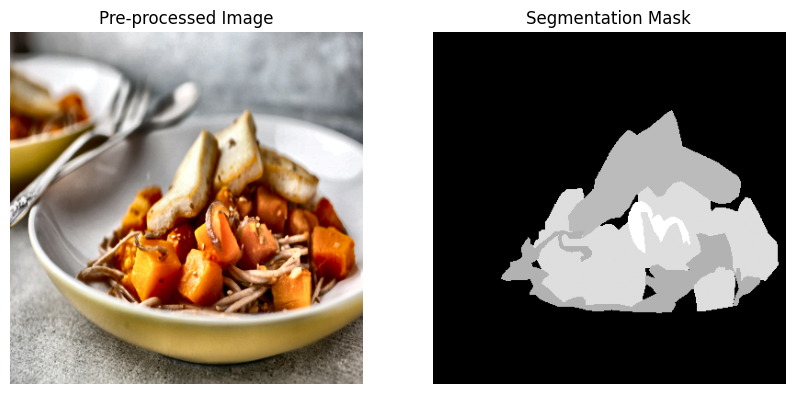

Unique values in mask:  [ 0 65 68 81 93]
Ingredient:  ['background', 'noodles', 'tofu', 'pumpkin', 'onion']


In [ ]:
# Function to unnormalize image
def unnormalize(tensor, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
    tensor = tensor.clone().detach().cpu().numpy()
    tensor = tensor * np.array(std).reshape(3, 1, 1) + np.array(mean).reshape(3, 1, 1)
    tensor = np.clip(tensor, 0, 1)  # Clip values to valid range
    return np.transpose(tensor, (1, 2, 0))  # Convert to (H, W, C)

# Get first batch
images, masks = next(iter(train_loader))
image = images[0]  # First image in batch
mask = masks[0]  # First mask in batch

# Unnormalize image
image = unnormalize(image)

# Convert mask to NumPy array for visualization
mask = mask.squeeze(0).cpu().numpy()  # Convert to (H, W)

# Plot the image and mask
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(image)
ax[0].set_title("Pre-processed Image")
ax[0].axis("off")

ax[1].imshow(mask, cmap="gray")  # Display mask in grayscale
ax[1].set_title("Segmentation Mask")
ax[1].axis("off")

plt.show()

print("Unique values in mask: ", np.unique(mask))
print("Ingredient: ", df.iloc[np.unique(mask)]['Category'].tolist())

### 6.4 Load base model (DeepLabV3 with RestNet101)

In [ ]:
# Dice Loss Created by: Zhang Shuai
class DiceLoss(nn.Module):
    """Dice Loss PyTorch
        Created by: Zhang Shuai
        Email: shuaizzz666@gmail.com
        dice_loss = 1 - 2*p*t / (p^2 + t^2). p and t represent predict and target.
    Args:
        weight: An array of shape [C,]
        predict: A float32 tensor of shape [N, C, *], for Semantic segmentation task is [N, C, H, W]
        target: A int64 tensor of shape [N, *], for Semantic segmentation task is [N, H, W]
    Return:
        diceloss
    """
    def __init__(self, weight=None):
        super(DiceLoss, self).__init__()
        if weight is not None:
            weight = torch.Tensor(weight)
            self.weight = weight / torch.sum(weight) # Normalized weight
        self.smooth = 1e-5

    def forward(self, predict, target):
        N, C = predict.size()[:2]
        predict = predict.view(N, C, -1) # (N, C, *)
        target = target.view(N, 1, -1) # (N, 1, *)

        predict = torch.nn.functional.softmax(predict, dim=1) # (N, C, *) ==> (N, C, *)
        ## convert target(N, 1, *) into one hot vector (N, C, *)
        target_onehot = torch.zeros(predict.size()).cuda()  # (N, 1, *) ==> (N, C, *)
        target_onehot.scatter_(1, target, 1)  # (N, C, *)

        intersection = torch.sum(predict * target_onehot, dim=2)  # (N, C)
        union = torch.sum(predict.pow(2), dim=2) + torch.sum(target_onehot, dim=2)  # (N, C)
        ## p^2 + t^2 >= 2*p*t, target_onehot^2 == target_onehot
        dice_coef = (2 * intersection + self.smooth) / (union + self.smooth)  # (N, C)

        if hasattr(self, 'weight'):
            if self.weight.type() != predict.type():
                self.weight = self.weight.type_as(predict)
                dice_coef = dice_coef * self.weight * C  # (N, C)
        dice_loss = 1 - torch.mean(dice_coef)  # 1

        return dice_loss

# Hybrid loss function
class HybridLoss(nn.Module):
    def __init__(self, dice_weight=1.0, ce_weight=1.0):
        super(HybridLoss, self).__init__()
        self.dice_loss = DiceLoss()
        self.ce_loss = torch.nn.CrossEntropyLoss()
        self.dice_weight = dice_weight
        self.ce_weight = ce_weight

    def forward(self, predict, target):
        dice = self.dice_loss(predict, target)
        ce = self.ce_loss(predict, target)
        return self.dice_weight * dice + self.ce_weight * ce

In [ ]:
# Load DeepLabV3 with ResNet-101 Backbone
model = torchvision.models.segmentation.deeplabv3_resnet101(
    weights=torchvision.models.segmentation.DeepLabV3_ResNet101_Weights.COCO_WITH_VOC_LABELS_V1
)

# Modify the classifier to output 104 classes (FoodSeg103)
num_classes = 104
model.classifier[4] = nn.Conv2d(256, num_classes, kernel_size=1)

# Move model to device (GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Unfreeze for fine-tuning
for name, param in model.backbone.named_parameters():
    if  "layer2" in name or "layer3" in name or "layer4" in name or "classifier" in name:
        param.requires_grad = True
    else:
        param.requires_grad = False

# Loss function and optimizer
criterion = HybridLoss(dice_weight=1.0, ce_weight=1.0)  # Hybrid loss function
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4)

# Learning rate scheduler
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)

# Set the model to training mode
model.train()

DeepLabV3(
  (backbone): IntermediateLayerGetter(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Se

### 6.5 Fine-tuning

In [ ]:
save_path = "/content/drive/MyDrive/CSC8645_Chatwipa/TASK 1/model"
date = datetime.today().strftime('%Y-%m-%d')

In [ ]:
# Number of epochs
num_epochs = 50

# Best validation loss initialization for model checkpointing
best_val_loss = float('inf')  # Initialize to infinity
patience = 5  # Early stopping patience (number of epochs without improvement)
epochs_without_improvement = 0

for epoch in range(num_epochs):
    model.train()  # Set model to training mode
    epoch_loss = 0

    # Training phase
    for images, masks in tqdm.tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Training", unit="batch"):
        images = images.to(device)
        masks = masks.squeeze(1).long().to(device)
        optimizer.zero_grad()
        outputs = model(images)['out']

        # Calculate loss
        loss = criterion(outputs, masks)
        loss.backward()

        # Update model weights
        optimizer.step()
        epoch_loss += loss.item()

    # Average training loss for this epoch
    avg_train_loss = epoch_loss / len(train_loader)

    # Validation phase
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for images, masks in tqdm.tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Validation", unit="batch"):
            images = images.to(device)
            masks = masks.squeeze(1).long().to(device)
            outputs = model(images)['out']

            # Calculate loss
            loss = criterion(outputs, masks)
            val_loss += loss.item()

    # Average validation loss for this epoch
    avg_val_loss = val_loss / len(val_loader)
    print(f"Epoch [{epoch+1}/{num_epochs}] - Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")

    # Save the model if validation loss improves
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(model.state_dict(), f'{save_path}/deeplabv3_HybridLoss_foodseg103_{date}.pth')
        epochs_without_improvement = 0  # Reset counter for early stopping
    else:
        epochs_without_improvement += 1

    # Early stopping check
    if epochs_without_improvement >= patience:
        print("Early stopping triggered. No improvement in validation loss.")
        break

    # Update learning rate scheduler
    scheduler.step(avg_val_loss)

print("Training complete. Best model saved.")

Epoch 1/50 - Validation: 100%|██████████| 47/47 [00:22<00:00,  2.12batch/s]


Epoch [1/50] - Train Loss: 3.0196, Val Loss: 2.4758


Epoch 2/50 - Validation: 100%|██████████| 47/47 [00:22<00:00,  2.13batch/s]


Epoch [2/50] - Train Loss: 2.3948, Val Loss: 2.2230


Epoch 3/50 - Validation: 100%|██████████| 47/47 [00:22<00:00,  2.14batch/s]


Epoch [3/50] - Train Loss: 2.1458, Val Loss: 2.1387


Epoch 4/50 - Validation: 100%|██████████| 47/47 [00:22<00:00,  2.13batch/s]


Epoch [4/50] - Train Loss: 1.9900, Val Loss: 2.1283


Epoch 5/50 - Validation: 100%|██████████| 47/47 [00:22<00:00,  2.13batch/s]


Epoch [5/50] - Train Loss: 1.8616, Val Loss: 2.1421


Epoch 6/50 - Validation: 100%|██████████| 47/47 [00:22<00:00,  2.13batch/s]


Epoch [6/50] - Train Loss: 1.6889, Val Loss: 1.9153


Epoch 7/50 - Validation: 100%|██████████| 47/47 [00:22<00:00,  2.13batch/s]


Epoch [7/50] - Train Loss: 1.4711, Val Loss: 1.8966


Epoch 8/50 - Validation: 100%|██████████| 47/47 [00:22<00:00,  2.12batch/s]


Epoch [8/50] - Train Loss: 1.3154, Val Loss: 1.8124


Epoch 9/50 - Validation: 100%|██████████| 47/47 [00:22<00:00,  2.13batch/s]


Epoch [9/50] - Train Loss: 1.2151, Val Loss: 1.7863


Epoch 10/50 - Validation: 100%|██████████| 47/47 [00:22<00:00,  2.13batch/s]


Epoch [10/50] - Train Loss: 1.1319, Val Loss: 1.7802


Epoch 11/50 - Validation: 100%|██████████| 47/47 [00:21<00:00,  2.14batch/s]


Epoch [11/50] - Train Loss: 1.0506, Val Loss: 1.7724


Epoch 12/50 - Validation: 100%|██████████| 47/47 [00:21<00:00,  2.15batch/s]


Epoch [12/50] - Train Loss: 1.0078, Val Loss: 1.7524


Epoch 13/50 - Validation: 100%|██████████| 47/47 [00:22<00:00,  2.14batch/s]


Epoch [13/50] - Train Loss: 0.9324, Val Loss: 1.7380


Epoch 14/50 - Validation: 100%|██████████| 47/47 [00:21<00:00,  2.14batch/s]


Epoch [14/50] - Train Loss: 0.8645, Val Loss: 1.9450


Epoch 15/50 - Validation: 100%|██████████| 47/47 [00:21<00:00,  2.14batch/s]


Epoch [15/50] - Train Loss: 0.9165, Val Loss: 1.8096


Epoch 16/50 - Validation: 100%|██████████| 47/47 [00:21<00:00,  2.14batch/s]


Epoch [16/50] - Train Loss: 0.8269, Val Loss: 1.7370


Epoch 17/50 - Validation: 100%|██████████| 47/47 [00:21<00:00,  2.14batch/s]


Epoch [17/50] - Train Loss: 0.7476, Val Loss: 1.7657


Epoch 18/50 - Validation: 100%|██████████| 47/47 [00:22<00:00,  2.13batch/s]


Epoch [18/50] - Train Loss: 0.6607, Val Loss: 1.6579


Epoch 19/50 - Validation: 100%|██████████| 47/47 [00:22<00:00,  2.14batch/s]


Epoch [19/50] - Train Loss: 0.6670, Val Loss: 1.9816


Epoch 20/50 - Validation: 100%|██████████| 47/47 [00:22<00:00,  2.12batch/s]


Epoch [20/50] - Train Loss: 0.6870, Val Loss: 1.8493


Epoch 21/50 - Validation: 100%|██████████| 47/47 [00:22<00:00,  2.13batch/s]


Epoch [21/50] - Train Loss: 0.6177, Val Loss: 1.8400


Epoch 22/50 - Validation: 100%|██████████| 47/47 [00:22<00:00,  2.13batch/s]


Epoch [22/50] - Train Loss: 0.5698, Val Loss: 1.7310


Epoch 23/50 - Validation: 100%|██████████| 47/47 [00:22<00:00,  2.13batch/s]


Epoch [23/50] - Train Loss: 0.4573, Val Loss: 1.5894


Epoch 24/50 - Validation: 100%|██████████| 47/47 [00:22<00:00,  2.13batch/s]


Epoch [24/50] - Train Loss: 0.3934, Val Loss: 1.5449


Epoch 25/50 - Validation: 100%|██████████| 47/47 [00:22<00:00,  2.14batch/s]


Epoch [25/50] - Train Loss: 0.3642, Val Loss: 1.5755


Epoch 26/50 - Validation: 100%|██████████| 47/47 [00:22<00:00,  2.14batch/s]


Epoch [26/50] - Train Loss: 0.3355, Val Loss: 1.6117


Epoch 27/50 - Validation: 100%|██████████| 47/47 [00:21<00:00,  2.14batch/s]


Epoch [27/50] - Train Loss: 0.3192, Val Loss: 1.6005


Epoch 28/50 - Validation: 100%|██████████| 47/47 [00:21<00:00,  2.14batch/s]


Epoch [28/50] - Train Loss: 0.3049, Val Loss: 1.6003


Epoch 29/50 - Validation: 100%|██████████| 47/47 [00:22<00:00,  2.14batch/s]

Epoch [29/50] - Train Loss: 0.2847, Val Loss: 1.5729
Early stopping triggered. No improvement in validation loss.
Training complete. Best model saved.


### 6.6 Evaluation

In [ ]:
# Path of model
model_path = '/content/drive/MyDrive/CSC8645_Chatwipa/TASK 1/model/deeplabv3_HybridLoss_foodseg103_2025-03-30.pth'

In [ ]:
# Load DeepLabV3 model with ResNet-101 backbone
model = torchvision.models.segmentation.deeplabv3_resnet101(weights=None)  # No pre-trained weights

# Modify the classifier to match FoodSeg103 (104 classes)
num_classes = 104
model.classifier[4] = torch.nn.Conv2d(256, num_classes, kernel_size=1)

# Move model to device (CPU/GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Load the saved state dict with strict=False
state_dict = torch.load(model_path, map_location=device)
# Filter out unexpected keys
state_dict = {k: v for k, v in state_dict.items() if 'aux_classifier' not in k}
model.load_state_dict(state_dict, strict=False)

# Set model to evaluation mode
model.eval()

DeepLabV3(
  (backbone): IntermediateLayerGetter(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Se

#### 6.6.1 Multi-classes mIoU

In [ ]:
# Load mean IoU evaluation metric
mean_iou = evaluate.load("mean_iou", trust_remote_code=True)
num_classes = 104

# Initialize variables to accumulate IoU values
total_mIoU = []
num_batches = 0

# Evaluation loop
with torch.no_grad():
    for images, masks in tqdm.tqdm(test_loader, desc="Evaluating mIoU", leave=False):
        images, masks = images.to(device), masks.to(device).long()

        # Get model predictions
        outputs = model(images)['out']
        predictions = torch.argmax(outputs, dim=1)

        # Convert tensors to numpy
        predicted = predictions.cpu().numpy()
        ground_truth = masks.cpu().numpy()

        # Compute mIoU for the batch
        evaluation_result = mean_iou.compute(predictions = predicted, references = ground_truth,
                                             num_labels = num_classes-1, ignore_index = 0)
        batch_mIoU = evaluation_result["mean_iou"]

        # Store result
        total_mIoU.append(batch_mIoU)
        num_batches += 1

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Evaluating mIoU:   0%|          | 0/134 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/datasets/features/image.py:347: UserWarning: Downcasting array dtype int64 to int32 to be compatible with 'Pillow'
  warnings.warn(f"Downcasting array dtype {dtype} to {dest_dtype} to be compatible with 'Pillow'")
/root/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/9e450724f21f05592bfb0255fe2fa576df8171fa060d11121d8aecfff0db80d0/mean_iou.py:259: Runtim

In [ ]:
# Compute overall mIoU
overall_mIoU = np.mean(total_mIoU)

print(f"Overall Mean IoU: {overall_mIoU:.4f}")

Overall Mean IoU: 0.3020


#### 6.6.2 Binary-class mIoU

In [ ]:
# Load evaluation function
mean_iou = evaluate.load("mean_iou", trust_remote_code=True)

# Define binary classes (0: Background, 1: Food)
num_classes = 2

# Initialize variables to accumulate IoU values
total_mIoU = []
num_batches = 0

# Loop for mIoU calculation
with torch.no_grad():
    for images, masks in tqdm.tqdm(test_loader, desc="Evaluating Binary mIoU", leave=False):
        images, masks = images.to(device), masks.to(device).long()

        # Get model predictions
        outputs = model(images)['out']
        predictions = torch.argmax(outputs, dim=1)

        # Convert multi-class to binary class (background: 0, food: 1)
        binary_ground_truth = (masks > 0).long()  # Convert all non-background classes to 1
        binary_predictions = (predictions > 0).long()  # Convert all non-background classes to 1

        # Convert tensors to numpy
        predicted_np = binary_predictions.cpu().numpy()
        ground_truth_np = binary_ground_truth.cpu().numpy()

        # Compute binary mIoU
        evaluation_result = mean_iou.compute(
            predictions = predicted_np,
            references = ground_truth_np,
            num_labels = num_classes,
            ignore_index = 255
        )
        batch_mIoU = evaluation_result["mean_iou"]

        # Store result
        total_mIoU.append(batch_mIoU)

In [ ]:
# Print final average mIoU
final_mIoU = np.mean(total_mIoU)
print(f"Binary mIoU: {final_mIoU:.4f}")

Binary mIoU: 0.9042


#### 6.6.3 Example result

In [ ]:
# Number of images to plot
num_images = 3

for i in range(num_images):

    # Create a figure
    fig, axes = plt.subplots(1, 3, figsize=(15, 5 * num_images))

    # Unnormalize and get images
    input_image = np.clip(images[1].cpu().numpy().transpose(1, 2, 0), 0, 1)
    input_image = unnormalize(images[i])

    # Get predicted and ground truth masks
    predicted_mask = predictions[i].cpu().numpy()
    ground_truth_mask = masks[i].cpu().numpy()

    # Plot input image
    axes[0].imshow(input_image)
    axes[0].set_title(f"Input Image {i+1}")
    axes[0].axis('off')

    # Plot predicted mask
    axes[1].imshow(predicted_mask, cmap="gray")
    axes[1].set_title(f"Predicted Mask {i+1}")
    axes[1].axis('off')

    # Plot ground truth mask
    axes[2].imshow(ground_truth_mask, cmap="gray")
    axes[2].set_title(f"Ground Truth Mask {i+1}")
    axes[2].axis('off')

    # Print real ingredients and predicted ingredients
    print(f"Input image {i+1}")
    print("Real Ingredients: ", df.iloc[np.unique(ground_truth_mask)]['Category'].tolist())
    print("Predicted Ingredients: ", df.iloc[np.unique(predicted_mask)]['Category'].tolist())

    # Adjust layout to prevent overlap
    plt.tight_layout()
    plt.show()

Output hidden; open in https://colab.research.google.com to view.

# Demonstration session

Load Library

In [1]:
!pip install opencv-python
!pip install -q evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 33.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 14.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 12.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 17.1 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cuda-cupti-cu12 12.

In [2]:
# Library for loading data
import zipfile
import os

# Library for deep learning
import torch
from torchvision.io import read_image
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
import torchvision
import torch.nn as nn
import torch.optim as optim
import torchvision.models.segmentation as models
import tqdm  # For progress bar
import torchvision.transforms.functional as F
from datetime import datetime

# Library for image processing
import cv2
from PIL import Image
import matplotlib.pyplot as plt

# Library for calculation
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
import evaluate # For calculate mIoU
import random

# Library for image plotting
import matplotlib.pyplot as plt

In [3]:
# Mount the drive with google colab notebook
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Load model

In [4]:
# Path of model
model_path = '/content/drive/MyDrive/CSC8645_Chatwipa/TASK 1/model/deeplabv3_HybridLoss_foodseg103_2025-03-30.pth'

In [5]:
# Load DeepLabV3 model with ResNet-101 backbone
model = torchvision.models.segmentation.deeplabv3_resnet101(weights=None)  # No pre-trained weights

# Modify the classifier to match FoodSeg103 (104 classes)
num_classes = 104
model.classifier[4] = torch.nn.Conv2d(256, num_classes, kernel_size=1)

# Move model to device (CPU/GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Load the saved state dict with strict=False
state_dict = torch.load(model_path, map_location=device)
# Filter out unexpected keys
state_dict = {k: v for k, v in state_dict.items() if 'aux_classifier' not in k}
model.load_state_dict(state_dict, strict=False)

# Set model to evaluation mode
model.eval()

Downloading: "https://download.pytorch.org/models/resnet101-63fe2227.pth" to /root/.cache/torch/hub/checkpoints/resnet101-63fe2227.pth
100%|██████████| 171M/171M [00:00<00:00, 195MB/s]


DeepLabV3(
  (backbone): IntermediateLayerGetter(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Se

### Load images

In [6]:
# Transforms for images
img_transform = transforms.Compose([
    transforms.Resize((384, 384)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Transforms for masks
mask_transform = transforms.Compose([
    transforms.Resize((384, 384), interpolation=transforms.InterpolationMode.NEAREST),
    transforms.ToTensor(),
    transforms.Lambda(lambda x: (x * 255).long().squeeze(0)),
])

In [7]:
# Define paths
image_dir = '/content/drive/MyDrive/CSC8645_Chatwipa/TASK 1/demo_test/img_dir'
mask_dir = '/content/drive/MyDrive/CSC8645_Chatwipa/TASK 1/demo_test/ann_dir'

# List all image files
image_files = sorted([f for f in os.listdir(image_dir) if f.endswith(('.jpg', '.png'))])

# Store images and masks in lists
image_list = []
mask_list = []

for img_name in image_files:
    img_path = os.path.join(image_dir, img_name)
    mask_path = os.path.join(mask_dir, img_name.replace('.jpg', '.png'))

    # Load and transform image
    image = Image.open(img_path).convert("RGB")
    image = img_transform(image).unsqueeze(0)
    image_list.append(image)

    # Load and transform mask
    mask = Image.open(mask_path).convert("L")
    mask = mask_transform(mask)
    mask_list.append(mask)

# Convert lists to tensors (optional)
image_tensor = torch.cat(image_list, dim=0)  # Shape: (batch_size, C, H, W)
mask_tensor = torch.stack(mask_list, dim=0)  # Shape: (batch_size, H, W)

print("Loaded", len(image_list), "images")
print("Image Tensor Shape:", image_tensor.shape)
print("Mask Tensor Shape:", mask_tensor.shape)

Loaded 3 images
Image Tensor Shape: torch.Size([3, 3, 384, 384])
Mask Tensor Shape: torch.Size([3, 384, 384])


In [11]:
# Load category label
category_file = "/content/drive/MyDrive/CSC8645_Chatwipa/TASK 1/demo_test/category_id.txt"
df = pd.read_csv(category_file, sep="\t", header=None, names=["ID", "Category"], engine="python")

df.head()

ID      Category
0   0    background
1   1         candy
2   2      egg tart
3   3  french fries
4   4     chocolate

### Evaluation

In [8]:
# Load evaluate funtion
mean_iou = evaluate.load("mean_iou", trust_remote_code=True)
num_classes = 104

# Initialize variables to accumulate IoU values
total_mIoU = []
num_batches = 0
prediction_list = []

# Loop for mIoU calculation
with torch.no_grad():
    for images, masks in tqdm.tqdm(zip(image_list, mask_list), desc="Evaluating mIoU", leave=False):
        images, masks = images.to(device), masks.to(device).long()

        # Get model predictions
        outputs = model(images)['out']
        predictions = torch.argmax(outputs, dim=1)
        prediction_list.append(predictions)

        # Convert tensors to numpy
        predicted = np.squeeze(predictions.cpu().numpy())
        ground_truth = masks.cpu().numpy()

        # Compute mIoU for the batch
        evaluation_result = mean_iou.compute(predictions=predicted, references=ground_truth,
                                             num_labels=num_classes, ignore_index=255)
        batch_mIoU = evaluation_result["mean_iou"]

        # Store result
        total_mIoU.append(batch_mIoU)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Evaluating mIoU: 0it [00:00, ?it/s]/usr/local/lib/python3.11/dist-packages/datasets/features/image.py:347: UserWarning: Downcasting array dtype int64 to int32 to be compatible with 'Pillow'
  warnings.warn(f"Downcasting array dtype {dtype} to {dest_dtype} to be compatible with 'Pillow'")
/root/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/9e450724f21f05592bfb0255fe2fa576df8171fa060d11121d8aecfff0db80d0/mean_iou.py:259: RuntimeWarning: invalid value encountered in divide
  iou = total_area_intersect / total_area_union
/root/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/9e450724f21f05592bfb0255fe2fa576df8171fa060d11121d8aecfff0db80d0/mean_iou.py:260: RuntimeWarning: invalid value encountered in divide
  acc = total_area_intersect / total_area_label


In [9]:
# Compute mIoU
final_mIoU = np.mean(total_mIoU)
print(f"Dataset Mean IoU: {final_mIoU:.4f}")

Dataset Mean IoU: 0.4566


No image test:  3


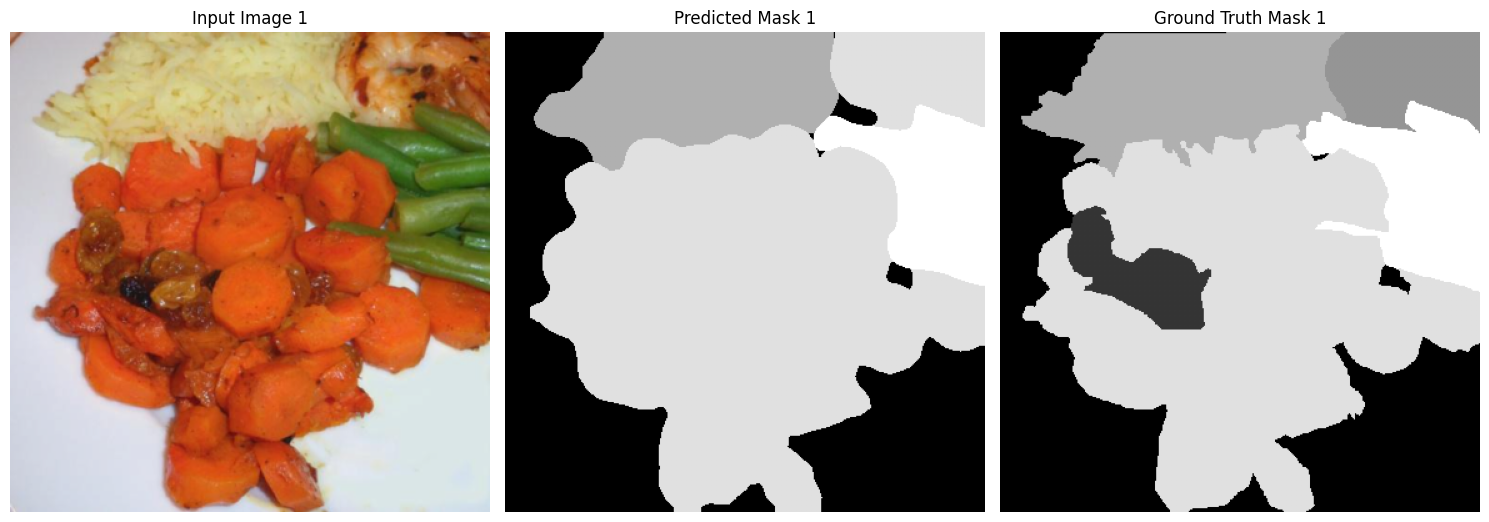

Input image 1
Real Ingredients:  ['background', 'dried cranberries', 'shrimp', 'rice', 'carrot', 'French beans']
Predicted Ingredients:  ['background', 'rice', 'carrot', 'French beans']


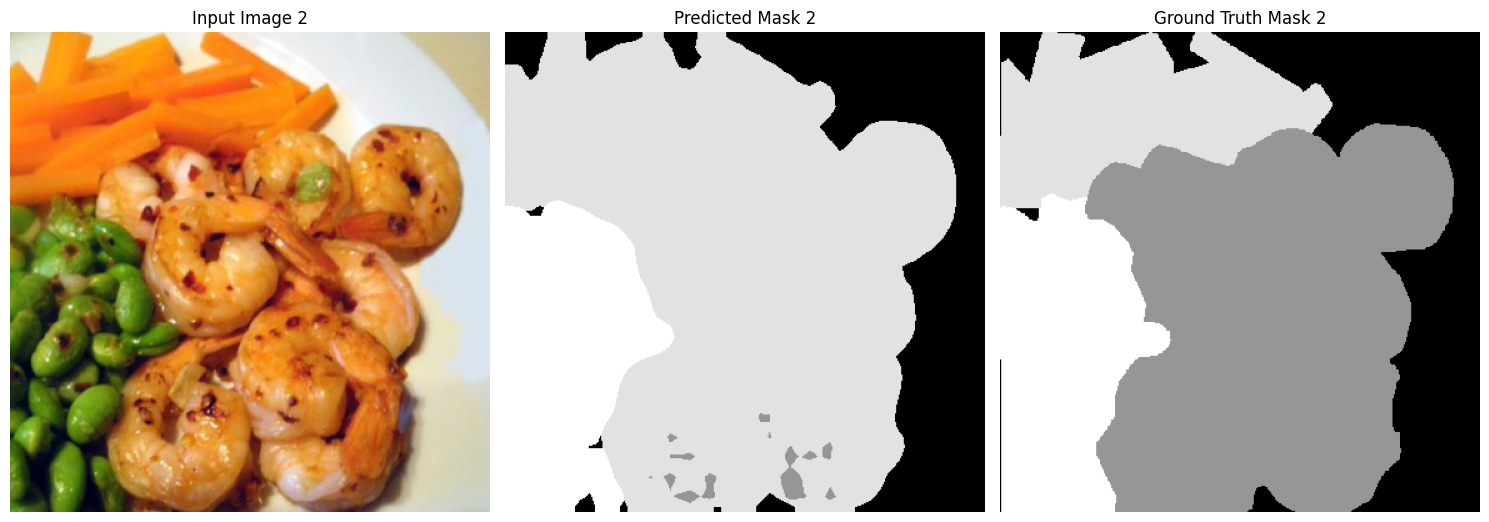

Input image 2
Real Ingredients:  ['background', 'shrimp', 'carrot', 'green beans']
Predicted Ingredients:  ['background', 'shrimp', 'carrot', 'green beans']


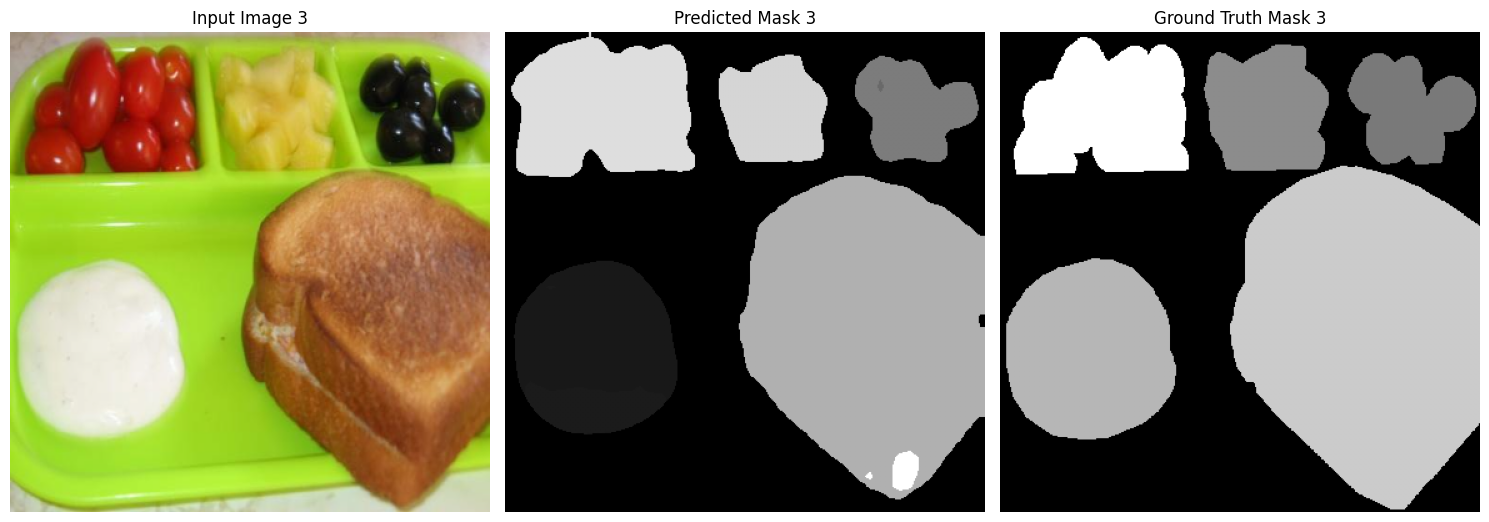

Input image 3
Real Ingredients:  ['background', 'olives', 'pineapple', 'sauce', 'bread', 'tomato']
Predicted Ingredients:  ['background', 'ice cream', 'cheese butter', 'olives', 'grape', 'bread', 'potato', 'tomato', 'carrot']


In [12]:
# Function to unnormalize image
def unnormalize(tensor, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
    tensor = tensor.clone().detach().cpu().numpy()
    tensor = tensor * np.array(std).reshape(3, 1, 1) + np.array(mean).reshape(3, 1, 1)
    tensor = np.clip(tensor, 0, 1)  # Clip values to valid range
    return np.transpose(tensor, (1, 2, 0))  # Convert to (H, W, C)

# Number of images to plot
num_images = len(image_list)
print('No image test: ', num_images)

for i in range(num_images):

    # Create a figure
    fig, axes = plt.subplots(1, 3, figsize=(15, 5 * num_images))

    # Input image
    input_image = unnormalize(image_list[i].squeeze(0))

    # Get predicted and ground truth masks
    predicted_mask = np.squeeze(prediction_list[i].cpu().numpy())
    ground_truth_mask = mask_list[i].cpu().numpy()

    # Plot input image
    axes[0].imshow(input_image)
    axes[0].set_title(f"Input Image {i+1}")
    axes[0].axis('off')

    # Plot predicted mask
    axes[1].imshow(predicted_mask, cmap="gray")
    axes[1].set_title(f"Predicted Mask {i+1}")
    axes[1].axis('off')

    # Plot ground truth mask
    axes[2].imshow(ground_truth_mask, cmap="gray")
    axes[2].set_title(f"Ground Truth Mask {i+1}")
    axes[2].axis('off')

    # Adjust layout to prevent overlap
    plt.tight_layout()
    plt.show()

    # Print real ingredients and predicted ingredients
    print(f"Input image {i+1}")
    print("Real Ingredients: ", df.iloc[np.unique(ground_truth_mask)]['Category'].tolist())
    print("Predicted Ingredients: ", df.iloc[np.unique(predicted_mask)]['Category'].tolist())